<a href="https://colab.research.google.com/github/eftekhar-hossain/CUET_NLP-EACL_2021/blob/main/Offensive_text_detection_(EACL_2021).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Libraries

In [ ]:
%%time
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import re
import nltk
import json
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
from sklearn.metrics import average_precision_score,roc_auc_score, roc_curve, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
np.random.seed(42)
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import ToktokTokenizer
import nltk, string, re, spacy,unicodedata, random
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings('ignore')
### Pretrained Word Embeddings
pretrained_path = "/content/drive/MyDrive/Colab Notebooks/PreTrained Wordembeddings/"
dataset_path = "/content/drive/MyDrive/Colab Notebooks/NLP Projects/EACL 2021- Shared Tasks/Offensive Language/Dataset/"
folder_path = "/content/drive/MyDrive/Colab Notebooks/NLP Projects/EACL 2021- Shared Tasks/Offensive Language/"

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
CPU times: user 1.17 s, sys: 545 ms, total: 1.71 s
Wall time: 5.01 s


# Tamil Offensive Dataset 

In [ ]:
%%time
train_data = pd.read_csv(dataset_path + "tamil_offensive_full_train.csv",delimiter='\t',header = None)
valid_data = pd.read_csv(dataset_path + "tamil_offensive_full_dev.csv",delimiter='\t',header = None)
test_data = pd.read_csv(dataset_path + "tamil_offensive_full_test.csv",delimiter='\t',header = None)

CPU times: user 89.1 ms, sys: 18.4 ms, total: 107 ms
Wall time: 2.78 s


In [ ]:
train_data = train_data.drop(columns=2)
train_data = train_data.rename(columns={0:'text',1:'label'})
valid_data = valid_data.drop(columns=2)
valid_data = valid_data.rename(columns={0:'text',1:'label'})
test_data = test_data.rename(columns={0:'text'})

In [ ]:
train_data['label'].value_counts()

Not_offensive                           25425
Offensive_Untargetede                    2906
Offensive_Targeted_Insult_Group          2557
Offensive_Targeted_Insult_Individual     2343
not-Tamil                                1454
Offensive_Targeted_Insult_Other           454
Name: label, dtype: int64

In [ ]:
valid_data['label'].value_counts()

Not_offensive                           3193
Offensive_Untargetede                    356
Offensive_Targeted_Insult_Individual     307
Offensive_Targeted_Insult_Group          295
not-Tamil                                172
Offensive_Targeted_Insult_Other           65
Name: label, dtype: int64

In [ ]:
train_data['enc_label'] = train_data['label'].replace({'Not_offensive':0, 'Offensive_Untargetede':1,'Offensive_Targeted_Insult_Group':2
                                                       ,'Offensive_Targeted_Insult_Individual':3,'not-Tamil':4,'Offensive_Targeted_Insult_Other':5
                                                       })
valid_data['enc_label'] = valid_data['label'].replace({'Not_offensive':0, 'Offensive_Untargetede':1,'Offensive_Targeted_Insult_Group':2
                                                       ,'Offensive_Targeted_Insult_Individual':3,'not-Tamil':4,'Offensive_Targeted_Insult_Other':5
                                                       })

In [ ]:
train_data

In [ ]:
train_data['text'].tolist()

In [ ]:
train_data['enc_label'].value_counts()

0    25425
1     2906
2     2557
3     2343
4     1454
5      454
Name: enc_label, dtype: int64

In [ ]:
valid_data['enc_label'].value_counts()

0    3193
1     356
3     307
2     295
4     172
5      65
Name: enc_label, dtype: int64

In [ ]:
print("Size of the training data ==> ", train_data.shape)
print("Size of the validation data ==>", valid_data.shape)
print("Size of the Test data ==>", test_data.shape)

Size of the training data ==>  (35139, 3)
Size of the validation data ==> (4388, 3)
Size of the Test data ==> (4392, 1)


## One Hot Encoding

In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

In [ ]:
encoder=OneHotEncoder(sparse=False)

encoded_labels = pd.DataFrame (encoder.fit_transform(train_data[['label']]))

encoded_labels .columns = encoder.get_feature_names(['label'])

train_data= pd.concat([train_data, encoded_labels ], axis=1)

In [ ]:
train_data.columns

Index(['text', 'label', 'enc_label', 'label_Not_offensive',
       'label_Offensive_Targeted_Insult_Group',
       'label_Offensive_Targeted_Insult_Individual',
       'label_Offensive_Targeted_Insult_Other', 'label_Offensive_Untargetede',
       'label_not-Tamil'],
      dtype='object')

In [ ]:
train_data = train_data.rename(columns={'label_Not_offensive':'Not_offensive','label_Offensive_Targeted_Insult_Group':'Offensive_Targeted_Insult_Group',
                                        'label_Offensive_Targeted_Insult_Individual':'Offensive_Targeted_Insult_Individual',
                                        'label_Offensive_Targeted_Insult_Other':'Offensive_Targeted_Insult_Other',
                                        'label_Offensive_Untargetede':'Offensive_Untargetede',
                                        'label_not-Tamil':'not-Tamil'})
train_data

## Cleaning

In [ ]:
'''
Text Cleaning
'''
def text_cleaning(row):
  # to remove HTML tags
  text = BeautifulSoup(row, 'html.parser').get_text()
  d = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE) #This line is for removing url
  post = d.replace('\n', '')
  post = post.replace('—', ' ')
  # to remove accented characters
  new_text = unicodedata.normalize('NFKD', post).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  # to remove special characters and numbers
  # define the pattern to keep
  #pat = r'[^a-zA-z0-9.,!?/:;\"\'\s]' 
  #text = re.sub(pat, '', new_text)
  #to remove punctuation
  text = ''.join([c for c in text if c not in string.punctuation])
  # to remove special characters
  pattern = r'^\s*|\s\s*'
  text = re.sub(pattern, ' ', text).strip()
  # convert into lower case
  text = text.lower() 
  # Stopword Removing
  tokenizer = ToktokTokenizer()
  # convert sentence into token of words
  tokens = tokenizer.tokenize(text)
  tokens = [token.strip() for token in tokens]
 

  return text



In [ ]:
#removing URLs and Punctuations
#train_data['cleaned'] = train_data['tweet'].apply(remove_url)
#Removing punctuations
train_data['cleaned'] = train_data['text'].apply(text_cleaning)
valid_data['cleaned'] = valid_data['text'].apply(text_cleaning)
test_data['cleaned'] = test_data['text'].apply(text_cleaning)


## Data samples after cleaning
print("Data samples after cleaning:\n")
for i in range(10):
  print("Original Data:===\n",train_data.text[i],"\nCleaned Data:===\n",train_data.cleaned[i],)

Data samples after cleaning:

Original Data:===
 movie vara level la Erika poguthu 
Cleaned Data:===
 movie vara level la erika poguthu
Original Data:===
 I love Ajith Kumar Vivegam movie inki mjy bht achi lgi 
Cleaned Data:===
 i love ajith kumar vivegam movie inki mjy bht achi lgi
Original Data:===
 Padam nalla comedy padama irukum polaye.. 
Cleaned Data:===
 padam nalla comedy padama irukum polaye
Original Data:===
 karthick subburaj anne .... intha padam vetri adaya unagalukku ennudaya valthukkal... 
Cleaned Data:===
 karthick subburaj anne intha padam vetri adaya unagalukku ennudaya valthukkal
Original Data:===
 கவுண்டர் தேவர்.சார்பாக வெற்றி பெற வாழ்த்துக்கள் 🦁 
Cleaned Data:===
 கவுண்டர் தேவர்சார்பாக வெற்றி பெற வாழ்த்துக்கள் 🦁
Original Data:===
 ippo intha trailer ah parkuravana oru like podunga 
Cleaned Data:===
 ippo intha trailer ah parkuravana oru like podunga
Original Data:===
 En thalaivan yogi babu irukkaar. Padam vera level laa irukkum 
Cleaned Data:===
 en thalaivan yogi

In [ ]:
valid_data['cleaned'].shape

(2843,)

## Data Statistics

In [ ]:
def char_length(row):
    return len(row.split())

In [ ]:
train_data.columns

Index(['text', 'label', 'enc_label', 'Not_offensive',
       'Offensive_Targeted_Insult_Group',
       'Offensive_Targeted_Insult_Individual',
       'Offensive_Targeted_Insult_Other', 'Offensive_Untargetede', 'not-Tamil',
       'cleaned'],
      dtype='object')

In [ ]:
lables = ['Not_offensive','Offensive_Targeted_Insult_Group','Offensive_Targeted_Insult_Individual',
       'Offensive_Targeted_Insult_Other', 'Offensive_Untargetede', 'not-Tamil']

# Count number of unique words in each set
def dataset_statistics(dataset):
  for l in lables:
    word_list = [word.strip() for t in list(dataset[dataset[l]==1.0].cleaned) for word in t.strip().split()]
    print(f"\nClass Name:--> {l} ") 
    print("Number of Words:{}".format(len(word_list))) 
    print("Number of Unique Words:{}".format(len(np.unique(word_list)))) 
    print("Maximum post length: {}".format(max(dataset[dataset[l]==1.0].cleaned.apply(char_length))))
    print("Average Words in texts: {}".format(np.mean(dataset[dataset[l]==1.0].cleaned.apply(char_length))))
    

In [ ]:
dataset_statistics(train_data)


Class Name:--> Not_offensive 
Number of Words:248076
Number of Unique Words:48547
Maximum post length: 87
Average Words in texts: 9.75716814159292

Class Name:--> Offensive_Targeted_Insult_Group 
Number of Words:38199
Number of Unique Words:15949
Maximum post length: 125
Average Words in texts: 14.938991005084082

Class Name:--> Offensive_Targeted_Insult_Individual 
Number of Words:25558
Number of Unique Words:10472
Maximum post length: 73
Average Words in texts: 10.9082373026035

Class Name:--> Offensive_Targeted_Insult_Other 
Number of Words:5103
Number of Unique Words:3063
Maximum post length: 59
Average Words in texts: 11.240088105726873

Class Name:--> Offensive_Untargetede 
Number of Words:28946
Number of Unique Words:10940
Maximum post length: 54
Average Words in texts: 9.960770818995183

Class Name:--> not-Tamil 
Number of Words:14511
Number of Unique Words:5427
Maximum post length: 73
Average Words in texts: 9.980055020632737


## Tweets length per class

In [ ]:
def comments_length_per_class(dataset,set_name):
  label = dataset[['Not_offensive','Offensive_Targeted_Insult_Group','Offensive_Targeted_Insult_Individual',
       'Offensive_Targeted_Insult_Other', 'Offensive_Untargetede', 'not-Tamil']]
  label = label.values
  comment = dataset['cleaned']
  comment = comment.values
  y = np.zeros(label.shape)
  for ix in range(comment.shape[0]):
      l = len(comment[ix].split())
      if label[ix][0] :
          y[ix][0] = l
      if label[ix][1] :
          y[ix][1] = l
  #color = ['red','green','blue','yellow','chartreuse'] 
  labelsplt = ['Not_offensive','Offensive_Targeted_Insult_Group','Offensive_Targeted_Insult_Individual',
       'Offensive_Targeted_Insult_Other', 'Offensive_Untargetede', 'not-Tamil']
  color = ['red','green','blue','yellow','chartreuse','magenta']    
  bins = [1,5,10,15,20,25,30]   
  plt.figure(figsize=(5,3)) 
  #plt.title ('Tweets Length Distribution Per Class')
  plt.hist(y,bins = bins,label = labelsplt,color = color)
  plt.axis([0, 80, 0, 1000])
  plt.xlabel('Length of texts')
  plt.ylabel('Number of texts') 
  plt.legend()
  #plt.savefig(path+'real-fake_no_title.png',dpi = 600,bbox_inches ='tight')
  #plt.grid(True)
  plt.show()

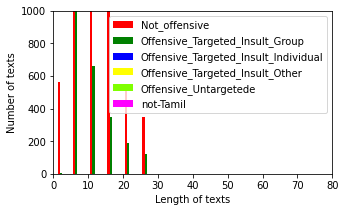

In [ ]:
comments_length_per_class(train_data,'Training')

##Ktrain -BERT

1. [Text Classification Using Transformers](https://nbviewer.jupyter.org/github/amaiya/ktrain/blob/master/tutorials/tutorial-A3-hugging_face_transformers.ipynb)

2. [Related Article](https://towardsdatascience.com/text-classification-with-hugging-face-transformers-in-tensorflow-2-without-tears-ee50e4f3e7ed)

3. [Ktrain](https://github.com/amaiya/ktrain)

In [ ]:
pip install ktrain

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 

In [ ]:
import ktrain
from ktrain import text

In [ ]:
train_data['label'].value_counts()

Not_offensive                           25425
Offensive_Untargetede                    2906
Offensive_Targeted_Insult_Group          2557
Offensive_Targeted_Insult_Individual     2343
not-Tamil                                1454
Offensive_Targeted_Insult_Other           454
Name: label, dtype: int64

In [ ]:
valid_data['label'].value_counts()

In [ ]:
categories = ['Not_offensive','Offensive_Targeted_Insult_Group','Offensive_Targeted_Insult_Individual',
       'Offensive_Targeted_Insult_Other', 'Offensive_Untargetede', 'not-Tamil']

In [ ]:
X_train = train_data['text'].tolist()
y_train = train_data['label'].tolist()

X_valid = valid_data['text'].tolist()
y_valid = valid_data['label'].tolist()

X_test = test_data['text'].tolist()
#y_test = test_data['label'].tolist()

In [ ]:
# 'bert-base-uncased'
# 'bert-base-multilingual-cased'
# 'distilbert-base-uncased'
# 'albert-base-v2'
# 'roberta-base'
# 'xlm-roberta-base'
# 'xlnet-base-cased'


In [ ]:
model_name = 'bert-base-multilingual-cased'
trans = text.Transformer(model_name,maxlen=50,class_names=categories)

In [ ]:
train = trans.preprocess_train(X_train,y_train)
valid = trans.preprocess_test(X_valid,y_valid)
#test = trans.preprocess_test(X_test,y_test)

preprocessing train...
language: id
train sequence lengths:
	mean : 10
	95percentile : 22
	99percentile : 43


Is Multi-Label? False
preprocessing test...
language: id
test sequence lengths:
	mean : 10
	95percentile : 22
	99percentile : 44


In [ ]:
model = trans.get_classifier()

In [ ]:
learner = ktrain.get_learner(model, train_data=train,val_data=valid, batch_size=12)

In [ ]:
#learner.lr_find(show_plot = True,max_epochs=10)

simulating training for different learning rates... this may take a few moments...


In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced'
                                               ,np.unique(train_data['label'])
                                               ,train_data['label'])

weight = {i : class_weights[i] for i in range(6)}
weight

{0: 0.2303441494591937,
 1: 2.2903793508017207,
 2: 2.4995731967562955,
 3: 12.89977973568282,
 4: 2.0153131452167927,
 5: 4.027854195323246}

In [ ]:
learner.fit_onecycle(2e-5,15,class_weight=weight)     #2e-5        

In [ ]:
learner.validate(class_names=categories)

                                      precision    recall  f1-score   support

                       Not_offensive       0.87      0.86      0.87      3193
     Offensive_Targeted_Insult_Group       0.29      0.34      0.31       295
Offensive_Targeted_Insult_Individual       0.39      0.36      0.37       307
     Offensive_Targeted_Insult_Other       0.03      0.02      0.02        65
               Offensive_Untargetede       0.34      0.38      0.36       356
                           not-Tamil       0.79      0.87      0.83       172

                            accuracy                           0.74      4388
                           macro avg       0.45      0.47      0.46      4388
                        weighted avg       0.74      0.74      0.74      4388



array([[2755,  150,   96,    8,  150,   34],
       [ 112,  100,   21,    6,   56,    0],
       [ 113,   36,  109,    4,   43,    2],
       [  35,   10,    6,    1,   12,    1],
       [ 122,   42,   42,   10,  136,    4],
       [  15,    2,    2,    0,    3,  150]])

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc=trans)

In [ ]:
# Save and load the model
predictor.save(folder_path+'Transformers_Models'+'/ta_offensive_m-bert_cw_predictor')

In [ ]:
predictor = ktrain.load_predictor(folder_path+'Transformers_Models'+'/ta_offensive_m-bert_predictor')

In [ ]:
y_pred = predictor.predict(X_test)
y_pred

In [ ]:
test_data['id'] = test_data.index+1

In [ ]:
run = pd.DataFrame(test_data['id'])
run['text'] = test_data['text']
run['label'] = y_pred
run

,id,text,label
0,1,14.12.2018 epo trailer pathutu irken ... Semay...,Not_offensive
1,2,Paka thana poro movie la Enna irukunu,Offensive_Targeted_Insult_Other
2,3,“U kena tunggu lebih lama lagi untuk tahu saya...,not-Tamil
3,4,Suriya anna vera level anna mass,Not_offensive
4,5,suma kaththaatha da sound over a pooda kudaath...,Offensive_Targeted_Insult_Individual
...,...,...,...
4387,4388,மண்ணு பொண்ணு ரெண்டுமே ஒன்னு அதுல எவன் கைய வச்ச...,Offensive_Targeted_Insult_Group
4388,4389,Babu mele ko ye song sunke kuch yesa feel hua ...,not-Tamil
4389,4390,asuran= aadukalam+pudupettai+ wada chennai..ye...,Not_offensive
4390,4391,Vijay's all movies look like same.,Not_offensive


In [ ]:
run['label'].value_counts()

Not_offensive                           3119
Offensive_Untargetede                    399
Offensive_Targeted_Insult_Group          382
Offensive_Targeted_Insult_Individual     318
not-Tamil                                159
Offensive_Targeted_Insult_Other           15
Name: label, dtype: int64

In [ ]:
run.to_csv(folder_path +'tamil_off_indic-bert_cw.csv',index = False)

##Machine Learning

In [ ]:
def print_metrices(true,pred):
    print(confusion_matrix(true,pred))
    print(classification_report(true,pred,))
    print("Accuracy : ",accuracy_score(true,pred))
    print("Precison : ",precision_score(true,pred, average = 'weighted'))
    print("Recall : ",recall_score(true,pred,  average = 'weighted'))
    print("F1 : ",f1_score(true,pred,  average = 'weighted'))

In [ ]:
## TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
#use_idf=True,tokenizer=lambda x: x.split()
vectorizer = TfidfVectorizer(tokenizer=lambda x: x.split())
vectorised_posts = vectorizer.fit_transform(train_data['cleaned'])
vectorized_train_posts = vectorizer.transform(train_data['cleaned'])
vectorized_valid_posts = vectorizer.transform(valid_data['cleaned'])
vectorized_test_posts = vectorizer.transform(test_data['cleaned'])

print("Feature Size: ", vectorized_train_posts.shape[1])
#vectorizer.vocabulary_

Feature Size:  71644


In [ ]:
vectorized_valid_posts.shape

(2843, 30528)

In [ ]:
valid_data['enc_label'].value_counts()

0    3193
1     356
3     307
2     295
4     172
5      65
Name: enc_label, dtype: int64

In [ ]:
labels = ['Not_offensive', 'Offensive_Untargetede','Offensive_Targeted_Insult_Group'
                                                       ,'Offensive_Targeted_Insult_Individual','not-Tamil','Offensive_Targeted_Insult_Other']
def actual_label(row):
    return labels[row]

###LR

In [ ]:
# After Tunning
# Optimum C = 100 
lr = LogisticRegression(C=10,class_weight='balanced')
lr.fit(vectorized_train_posts,train_data['enc_label'])
y_pred = lr.predict(vectorized_valid_posts)
print_metrices(y_pred,valid_data['enc_label'])

[[2291  242  312  241   55   52]
 [  68  172   40   55    6   15]
 [  42   59  143   40    3    8]
 [  35   68   44  144    7    9]
 [  18    7    1    6  139    1]
 [  11   31   10    7    2    4]]
              precision    recall  f1-score   support

           0       0.93      0.72      0.81      3193
           1       0.30      0.48      0.37       356
           2       0.26      0.48      0.34       295
           3       0.29      0.47      0.36       307
           4       0.66      0.81      0.72       172
           5       0.04      0.06      0.05        65

    accuracy                           0.66      4388
   macro avg       0.41      0.50      0.44      4388
weighted avg       0.76      0.66      0.70      4388

Accuracy :  0.6592980856882407
Precison :  0.6205682353463898
Recall :  0.6592980856882407
F1 :  0.6223750903258926


In [ ]:
test_pred = lr.predict(vectorized_test_posts).tolist()
test_data['id'] = test_data.index + 1

In [ ]:
run = pd.DataFrame(test_data['id'])
run['text'] = test_data['text']
run['label'] = test_pred
run['label'] = run['label'].apply(actual_label)
run 

,id,text,label
0,1,14.12.2018 epo trailer pathutu irken ... Semay...,Not_offensive
1,2,Paka thana poro movie la Enna irukunu,Offensive_Untargetede
2,3,“U kena tunggu lebih lama lagi untuk tahu saya...,not-Tamil
3,4,Suriya anna vera level anna mass,Not_offensive
4,5,suma kaththaatha da sound over a pooda kudaath...,Offensive_Targeted_Insult_Individual
...,...,...,...
4387,4388,மண்ணு பொண்ணு ரெண்டுமே ஒன்னு அதுல எவன் கைய வச்ச...,Not_offensive
4388,4389,Babu mele ko ye song sunke kuch yesa feel hua ...,not-Tamil
4389,4390,asuran= aadukalam+pudupettai+ wada chennai..ye...,Offensive_Untargetede
4390,4391,Vijay's all movies look like same.,Not_offensive


In [ ]:
run.to_csv(folder_path +'tamil_off_lr.csv',index = False)

###SVM

In [ ]:
## SVM
from sklearn.svm import SVC
svc =  SVC(kernel='linear' C = 5,random_state=1234,class_weight='balanced')
svc.fit(vectorized_train_posts,train_data['enc_label'])
y_pred = svc.predict(vectorized_valid_posts)
print_metrices(y_pred,valid_data['enc_label'])

[[2493  213  242  197   40    8]
 [  81  163   52   52    4    4]
 [  61   59  130   41    2    2]
 [  56   66   40  140    3    2]
 [  34    4    0    3  131    0]
 [  20   27   12    4    0    2]]
              precision    recall  f1-score   support

           0       0.91      0.78      0.84      3193
           1       0.31      0.46      0.37       356
           2       0.27      0.44      0.34       295
           3       0.32      0.46      0.38       307
           4       0.73      0.76      0.74       172
           5       0.11      0.03      0.05        65

    accuracy                           0.70      4388
   macro avg       0.44      0.49      0.45      4388
weighted avg       0.76      0.70      0.72      4388

Accuracy :  0.6971285323609845
Precison :  0.6685259989818864
Recall :  0.6971285323609845
F1 :  0.6745771763163315


In [ ]:
test_pred = svc.predict(vectorized_test_posts).tolist()
test_data['id'] = test_data.index + 1

In [ ]:
run = pd.DataFrame(test_data['id'])
run['text'] = test_data['text']
run['label'] = test_pred
run['label'] = run['label'].apply(actual_label)
run 

,id,text,label
0,1,14.12.2018 epo trailer pathutu irken ... Semay...,Not_offensive
1,2,Paka thana poro movie la Enna irukunu,Not_offensive
2,3,“U kena tunggu lebih lama lagi untuk tahu saya...,not-Tamil
3,4,Suriya anna vera level anna mass,Not_offensive
4,5,suma kaththaatha da sound over a pooda kudaath...,Offensive_Targeted_Insult_Individual
...,...,...,...
4387,4388,மண்ணு பொண்ணு ரெண்டுமே ஒன்னு அதுல எவன் கைய வச்ச...,Offensive_Targeted_Insult_Group
4388,4389,Babu mele ko ye song sunke kuch yesa feel hua ...,not-Tamil
4389,4390,asuran= aadukalam+pudupettai+ wada chennai..ye...,Offensive_Untargetede
4390,4391,Vijay's all movies look like same.,Not_offensive


In [ ]:
run.to_csv(folder_path +'tamil_off_svm.csv',index = False)

###Ensemble Approach()

In [ ]:
LogReg_clf = LogisticRegression(class_weight='balanced')
DTree_clf = DecisionTreeClassifier(class_weight='balanced')
rt_clf =   RandomForestClassifier(class_weight='balanced')
SVC_clf = SVC(class_weight='balanced')


voting_clf = VotingClassifier(estimators=[('SVC', SVC_clf), ('DTree', DTree_clf), ('LogReg', LogReg_clf),('RF', rt_clf)], voting='hard')
voting_clf.fit(vectorized_train_posts, train_data['enc_label'])
preds = voting_clf.predict(vectorized_valid_posts)



In [ ]:
print_metrices(valid_data['enc_label'],preds)

[[2945   88   91   53   16    0]
 [ 199  110   22   21    3    1]
 [ 169   39   73   11    1    2]
 [ 174   39   20   72    1    1]
 [  56    2    0    0  114    0]
 [  43   15    5    2    0    0]]
              precision    recall  f1-score   support

           0       0.82      0.92      0.87      3193
           1       0.38      0.31      0.34       356
           2       0.35      0.25      0.29       295
           3       0.45      0.23      0.31       307
           4       0.84      0.66      0.74       172
           5       0.00      0.00      0.00        65

    accuracy                           0.76      4388
   macro avg       0.47      0.40      0.42      4388
weighted avg       0.72      0.76      0.73      4388

Accuracy :  0.7552415679124886
Precison :  0.7160952198857428
Recall :  0.7552415679124886
F1 :  0.7298705505654587


In [ ]:
test_pred = voting_clf.predict(vectorized_test_posts).tolist()
test_data['id'] = test_data.index + 1

In [ ]:
run = pd.DataFrame(test_data['id'])
run['text'] = test_data['text']
run['label'] = test_pred
run['label'] = run['label'].apply(actual_label)
run 

In [ ]:
run.to_csv(folder_path +'tamil_off_voting.csv',index = False)

##Deep Learning

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import regularizers
from tensorflow.keras.layers import LSTM,GRU
from tensorflow.keras.models import load_model
print("Tensorflow Version:--",tf.version.VERSION)
print("Keras Version:---",keras.__version__)

Tensorflow Version:-- 2.4.0
Keras Version:--- 2.4.0


###Tokenization

In [ ]:
tokenizer = Tokenizer(num_words = 20000,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n-', 
                      split=' ', char_level=False, oov_token='<oov>', document_count=0)
tokenizer.fit_on_texts(train_data['text'])  
word_index = tokenizer.word_index
vocab_size = len(word_index)+1

In [ ]:
print(vocab_size)

68068


In [ ]:
max_len = 50
# Training Sequences
train_sequences = tokenizer.texts_to_sequences(train_data['text'])
print(len(tokenizer.word_index))
train_pad_sequences =  keras.preprocessing.sequence.pad_sequences(train_sequences, value=0.0, padding='post', maxlen= max_len)
print("Number of Training Sequences :" ,train_pad_sequences.shape)

# Validation Sequences
validation_sequences = tokenizer.texts_to_sequences(valid_data['text'])
validation_pad_sequences =  keras.preprocessing.sequence.pad_sequences(validation_sequences, value=0.0, padding='post', maxlen= max_len)
print("Number of Validation Sequences :" ,validation_pad_sequences.shape)

68067
Number of Training Sequences : (35139, 50)
Number of Validation Sequences : (4388, 50)


In [ ]:
# Test Sequences
test_sequences = tokenizer.texts_to_sequences(test_data['text'])
test_pad_sequences =  keras.preprocessing.sequence.pad_sequences(test_sequences, value=0.0, padding='post', maxlen= max_len)
print("Number of Test Sequences :" ,test_pad_sequences.shape)

Number of Test Sequences : (4392, 50)


In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced'
                                               ,np.unique(train_data['enc_label'])
                                               ,train_data['enc_label'])

weight = {i : class_weights[i] for i in range(6)}

In [ ]:
weight

{0: 0.2303441494591937,
 1: 2.0153131452167927,
 2: 2.2903793508017207,
 3: 2.4995731967562955,
 4: 4.027854195323246,
 5: 12.89977973568282}

In [ ]:
num_classes = 6

accuracy_threshold = 0.99

class myCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
      if(logs.get('accuracy')>accuracy_threshold):
        print("\nReached %2.2f%% accuracy so we will stop trianing" % (accuracy_threshold*100))
        self.model.stop_training = True

acc_callback = myCallback()
# Saved the Best Model
filepath = folder_path+"ta_off_BiLSTMModel.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True, 
                                             save_weights_only=False, mode='max')
# callback list
callback_list = [acc_callback, checkpoint] 
model = tf.keras.models.Sequential([
tf.keras.layers.Embedding(vocab_size, 100, input_length = max_len),
#tf.keras.layers.Conv1D(128, 5, activation='relu'),
#tf.keras.layers.MaxPooling1D(5),
tf.keras.layers.Bidirectional(LSTM(units = 100,return_sequences=True,dropout = 0.2)),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(6 , activation='softmax')])

model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 100)           6806800   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 50, 200)           160800    
_________________________________________________________________
flatten_3 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 60006     
Total params: 7,027,606
Trainable params: 7,027,606
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])
   
history = model.fit(train_pad_sequences,
    train_data['enc_label'],
    epochs=15,
    batch_size = 64,
    validation_split = 0.2,
    verbose =1,
    callbacks = callback_list,
    class_weight = weight)

Epoch 1/15
440/440 [==============================] - 29s 57ms/step - loss: 0.0732 - accuracy: 0.9553 - val_loss: 1.7788 - val_accuracy: 0.6682

Epoch 00001: val_accuracy did not improve from 0.68099
Epoch 2/15
440/440 [==============================] - 24s 54ms/step - loss: 0.0592 - accuracy: 0.9647 - val_loss: 2.2006 - val_accuracy: 0.6389

Epoch 00002: val_accuracy did not improve from 0.68099
Epoch 3/15
440/440 [==============================] - 24s 54ms/step - loss: 0.0589 - accuracy: 0.9660 - val_loss: 2.2342 - val_accuracy: 0.6330

Epoch 00003: val_accuracy did not improve from 0.68099
Epoch 4/15
440/440 [==============================] - 24s 55ms/step - loss: 0.0458 - accuracy: 0.9715 - val_loss: 2.2371 - val_accuracy: 0.6938

Epoch 00004: val_accuracy improved from 0.68099 to 0.69380, saving model to /content/drive/MyDrive/Colab Notebooks/NLP Projects/EACL 2021- Shared Tasks/Offensive Language/ta_off_BiLSTMModel.h5
Epoch 5/15
440/440 [==============================] - 24s 54ms

In [ ]:
# Load the saved model
model = load_model(folder_path+'ta_off_BiLSTMModel.h5')
# prediction
y_pred = np.argmax(model.predict(validation_pad_sequences), axis=-1)

print("F1-Score:",f1_score(valid_data['enc_label'],y_pred,average = 'weighted')*100)
print("Accuracy:",accuracy_score(valid_data['enc_label'],y_pred)*100)

F1-Score: 69.53583165889337
Accuracy: 68.23154056517777


In [ ]:
from sklearn.metrics import classification_report

#Show precision and recall per genre
print_metrices(valid_data['enc_label'],y_pred)

[[2587  170  175  171   42   48]
 [ 120  112   49   51    6   18]
 [ 117   52   72   37    4   13]
 [ 109   52   34  101    2    9]
 [  36    8    2    4  121    1]
 [  28   21    6    8    1    1]]
              precision    recall  f1-score   support

           0       0.86      0.81      0.84      3193
           1       0.27      0.31      0.29       356
           2       0.21      0.24      0.23       295
           3       0.27      0.33      0.30       307
           4       0.69      0.70      0.70       172
           5       0.01      0.02      0.01        65

    accuracy                           0.68      4388
   macro avg       0.39      0.40      0.39      4388
weighted avg       0.71      0.68      0.70      4388

Accuracy :  0.6823154056517776
Precison :  0.7104439921907858
Recall :  0.6823154056517776
F1 :  0.6953583165889338


### Test Set Prediction

In [ ]:
test_pred = np.argmax(model.predict(test_pad_sequences), axis=-1).tolist()
test_pred

In [ ]:
test_data['id'] = test_data.index + 1
run = pd.DataFrame(test_data['id'])
run['text'] = test_data['text']
run['label'] = test_pred
run['label'] = run['label'].apply(actual_label)
run 

In [ ]:
run.to_csv(folder_path +'tamil_bilstm.csv',index = False)

##Pretrained Embedding

In [ ]:
from urllib.request import urlopen
import gzip

# get the vectors
file = gzip.open(urlopen('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ta.300.vec.gz'))

In [ ]:
vocab_and_vectors = {}
# put words as dict indexes and vectors as words values
for line in file:
  values = line.split()
  word = values [0].decode('utf-8')
  vector = np.asarray(values[1:], dtype='float32')
  vocab_and_vectors[word] = vector

In [ ]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in word_index.items():
  embedding_vector = vocab_and_vectors.get(word)
  # words that cannot be found will be set to 0
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

###Model Defination

In [ ]:
num_classes = 6

accuracy_threshold = 0.99

class myCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
      if(logs.get('accuracy')>accuracy_threshold):
        print("\nReached %2.2f%% accuracy so we will stop trianing" % (accuracy_threshold*100))
        self.model.stop_training = True

acc_callback = myCallback()
# Saved the Best Model
filepath = folder_path+"prt_ta-off-BiLSTMModel.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True, 
                                             save_weights_only=False, mode='max')
# callback list
callback_list = [acc_callback, checkpoint] 
model = tf.keras.models.Sequential([
tf.keras.layers.Embedding(vocab_size, 300,weights=[embedding_matrix],trainable=False, input_length = max_len),
#tf.keras.layers.Conv1D(128, 5, activation='relu'),
#tf.keras.layers.MaxPooling1D(5),
tf.keras.layers.Bidirectional(LSTM(units = 200,return_sequences=True,dropout = 0.2)),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(6 , activation='softmax')])

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 300)           20420400  
_________________________________________________________________
conv1d (Conv1D)              (None, 46, 128)           192128    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 9, 128)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 9, 400)            526400    
_________________________________________________________________
flatten (Flatten)            (None, 3600)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 21606     
Total params: 21,160,534
Trainable params: 740,134
Non-trainable params: 20,420,400
______________________________________

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])
   
history = model.fit(train_pad_sequences,
    train_data['enc_label'],
    epochs=50,
    batch_size = 64,
    validation_split = 0.2,
    verbose =1,
    callbacks = callback_list,
    class_weight = weight)

Epoch 1/50
440/440 [==============================] - 15s 12ms/step - loss: 1.6029 - accuracy: 0.3156 - val_loss: 1.3520 - val_accuracy: 0.5063

Epoch 00001: val_accuracy improved from -inf to 0.50626, saving model to /content/drive/MyDrive/Colab Notebooks/NLP Projects/EACL 2021- Shared Tasks/Offensive Language/prt_ta-off-BiLSTMModel.h5
Epoch 2/50
440/440 [==============================] - 4s 9ms/step - loss: 1.4173 - accuracy: 0.4732 - val_loss: 1.5165 - val_accuracy: 0.4190

Epoch 00002: val_accuracy did not improve from 0.50626
Epoch 3/50
440/440 [==============================] - 4s 9ms/step - loss: 1.3274 - accuracy: 0.5002 - val_loss: 1.4796 - val_accuracy: 0.4225

Epoch 00003: val_accuracy did not improve from 0.50626
Epoch 4/50
440/440 [==============================] - 4s 9ms/step - loss: 1.2147 - accuracy: 0.5229 - val_loss: 1.2941 - val_accuracy: 0.5087

Epoch 00004: val_accuracy improved from 0.50626 to 0.50868, saving model to /content/drive/MyDrive/Colab Notebooks/NLP Pro

In [ ]:
# Load the saved model
model = load_model(folder_path+'prt_ta-off-BiLSTMModel.h5')
# prediction
y_pred = np.argmax(model.predict(validation_pad_sequences), axis=-1)
print_metrices(y_pred,valid_data['enc_label'])


[[2516  149  114  135   28   32]
 [ 200  102   50   42    5   13]
 [ 176   47   79   31    2    7]
 [ 211   44   37   91   10    9]
 [  68    7    6    4  127    3]
 [  22    7    9    4    0    1]]
              precision    recall  f1-score   support

           0       0.79      0.85      0.82      2974
           1       0.29      0.25      0.27       412
           2       0.27      0.23      0.25       342
           3       0.30      0.23      0.26       402
           4       0.74      0.59      0.66       215
           5       0.02      0.02      0.02        43

    accuracy                           0.66      4388
   macro avg       0.40      0.36      0.38      4388
weighted avg       0.65      0.66      0.65      4388

Accuracy :  0.6645396536007293
Precison :  0.6453136493694644
Recall :  0.6645396536007293
F1 :  0.6531494649694097


In [ ]:
test_pred = np.argmax(model.predict(test_pad_sequences), axis=-1).tolist()
test_pred

In [ ]:
test_data['id'] = test_data.index + 1
run = pd.DataFrame(test_data['id'])
run['text'] = test_data['text']
run['label'] = test_pred
run['label'] = run['label'].apply(actual_label)
run 

In [ ]:
run.to_csv(folder_path +'tamil_cnn+bilstm+fasttext.csv',index = False)

## Attention

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Concatenate, Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Flatten
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Convolution1D
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.layers import Add, BatchNormalization, Activation, Dropout

In [ ]:
MAX_FEATURES = 10000
EMBED_SIZE = 128
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(train_data['cleaned'])
list_tokenized_train = tokenizer.texts_to_sequences(train_data['cleaned'])
list_tokenized_val = tokenizer.texts_to_sequences(valid_data['cleaned'])  
list_tokenized_test = tokenizer.texts_to_sequences(test_data['cleaned'])  
RNN_CELL_SIZE = 100
  
MAX_LEN = 70  
X_train = pad_sequences(list_tokenized_train, maxlen=MAX_LEN)
y_train = train_data['enc_label']
X_val = pad_sequences(list_tokenized_val, maxlen=MAX_LEN)
y_val = valid_data['enc_label']
X_test = pad_sequences(list_tokenized_test, maxlen=MAX_LEN)

In [ ]:
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
          
        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = tf.nn.tanh(
            self.W1(features) + self.W2(hidden_with_time_axis))
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
          
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

In [ ]:
sequence_input = Input(shape=(MAX_LEN,), dtype="int32")
embedded_sequences = Embedding(MAX_FEATURES, EMBED_SIZE)(sequence_input)

In [ ]:
#conv = Convolution1D(128,5,activation='relu')(embedded_sequences)
#pol = GlobalMaxPool1D()(conv)

lstm = Bidirectional(LSTM(64, return_sequences = True), name="bi_lstm_0")(embedded_sequences)

# Getting our LSTM outputs
(lstm, forward_h, forward_c, backward_h, backward_c) = Bidirectional(LSTM(64, return_sequences=True, return_state=True), name="bi_lstm_1")(lstm)

In [ ]:
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
context_vector, attention_weights = Attention(20)(lstm, state_h)
dense1 = Dense(20, activation="relu")(context_vector)
dropout = Dropout(0.1)(dense1)
output = Dense(6, activation="softmax")(dropout)
  
model = keras.Model(inputs=sequence_input, outputs=output)

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer= keras.optimizers.Adam(learning_rate = 0.001),
              metrics=['accuracy'])

In [ ]:
BATCH_SIZE = 64
EPOCHS = 5
history = model.fit(X_train,y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.10)

Epoch 1/5
495/495 [==============================] - 23s 31ms/step - loss: 1.0296 - accuracy: 0.7096 - val_loss: 0.7643 - val_accuracy: 0.7555
Epoch 2/5
495/495 [==============================] - 14s 28ms/step - loss: 0.6933 - accuracy: 0.7652 - val_loss: 0.6951 - val_accuracy: 0.7649
Epoch 3/5
495/495 [==============================] - 14s 28ms/step - loss: 0.5546 - accuracy: 0.8089 - val_loss: 0.7114 - val_accuracy: 0.7547
Epoch 4/5
495/495 [==============================] - 14s 28ms/step - loss: 0.4588 - accuracy: 0.8436 - val_loss: 0.7764 - val_accuracy: 0.7544
Epoch 5/5
495/495 [==============================] - 14s 27ms/step - loss: 0.3769 - accuracy: 0.8759 - val_loss: 0.8670 - val_accuracy: 0.7325


In [ ]:
prediction = np.argmax(model.predict(X_val),axis = -1)
print_metrices(valid_data['enc_label'],prediction)

[[2784  114  114  131   50    0]
 [ 135  124   32   52   13    0]
 [ 143   38   62   44    8    0]
 [ 120   58   41   78   10    0]
 [  36    2    0    0  134    0]
 [  31   17    5    9    3    0]]
              precision    recall  f1-score   support

           0       0.86      0.87      0.86      3193
           1       0.35      0.35      0.35       356
           2       0.24      0.21      0.23       295
           3       0.25      0.25      0.25       307
           4       0.61      0.78      0.69       172
           5       0.00      0.00      0.00        65

    accuracy                           0.73      4388
   macro avg       0.39      0.41      0.40      4388
weighted avg       0.71      0.73      0.72      4388

Accuracy :  0.7251595259799453
Precison :  0.7099048289183952
Recall :  0.7251595259799453
F1 :  0.7170167238900832


In [ ]:
test_pred = np.argmax(model.predict(X_test), axis=-1).tolist()
test_data['id'] = test_data.index + 1
run = pd.DataFrame(test_data['id'])
run['text'] = test_data['text']
run['label'] = test_pred
run['label'] = run['label'].apply(actual_label)
run 

In [ ]:
run['label'].value_counts()

In [ ]:
run.to_csv(folder_path +'NLP@CUET_tamil-10.csv',index = False)

# Malaylam Dataset 

In [ ]:
%%time
train_data = pd.read_csv(dataset_path + "mal_full_offensive_train.csv",delimiter='\t',header = None)
valid_data = pd.read_csv(dataset_path + "mal_full_offensive_dev.csv",delimiter='\t',header = None)
test_data = pd.read_csv(dataset_path + "mal_full_offensive_test.csv",delimiter='\t',header = None)

CPU times: user 40.4 ms, sys: 4.78 ms, total: 45.1 ms
Wall time: 1.59 s


In [ ]:
train_data = train_data.drop(columns=2)
train_data = train_data.rename(columns={0:'text',1:'label'})
valid_data = valid_data.drop(columns=2)
valid_data = valid_data.rename(columns={0:'text',1:'label'})
test_data = test_data.rename(columns={0:'text'})

In [ ]:
train_data['label'].value_counts()

Not_offensive                           14153
not-malayalam                            1287
Offensive_Targeted_Insult_Individual      239
Offensive_Untargetede                     191
Offensive_Targeted_Insult_Group           140
Name: label, dtype: int64

In [ ]:
valid_data['label'].value_counts()

Not_offensive                           1779
not-malayalam                            163
Offensive_Targeted_Insult_Individual      24
Offensive_Untargetede                     20
Offensive_Targeted_Insult_Group           13
Name: label, dtype: int64

In [ ]:
train_data['enc_label'] = train_data['label'].replace({'Not_offensive':0, 'not-malayalam':1,'Offensive_Targeted_Insult_Individual':2
                                                       ,'Offensive_Untargetede':3,'Offensive_Targeted_Insult_Group':4
                                                       })
valid_data['enc_label'] = valid_data['label'].replace({'Not_offensive':0, 'not-malayalam':1,'Offensive_Targeted_Insult_Individual':2
                                                       ,'Offensive_Untargetede':3,'Offensive_Targeted_Insult_Group':4
                                                       })

In [ ]:
train_data

,text,label,enc_label
0,പലദേശം. പല ഭാഷ ഒരേ ഒരു രാജാവ് അല്ലാതെ സ്വന്ത...,Not_offensive,0
1,ഈ ഓണം ഏട്ടനും പിള്ളേർക്ക് ഉള്ളതാണ് എന്ന് ഉള്ളവ...,Not_offensive,0
2,ആരണ്ട ആരണ്ട തലുണ്ടാകാണാ ആരണ്ട ഞാൻ ആണ്ട ഞാൻ ആണ്...,Not_offensive,0
3,Sushin syam Shaiju khalid Midhun manual,Not_offensive,0
4,J A K E S. B EJ O Y !!!,Not_offensive,0
...,...,...,...
16005,കട്ട ലാലേട്ടൻ ഫാൻസിന് ദൈവത്തെ ഓർത്ത് അമിത പ്രത...,Not_offensive,0
16006,ente mammookka ningal puliyalla oru simhama......,Not_offensive,0
16007,Lucifer mass dialogues Ellam onnu comment chey...,Not_offensive,0
16008,Like from Madurai (Tamil nadu) ....,not-malayalam,1


In [ ]:
train_data['text'].tolist()

In [ ]:
train_data['enc_label'].value_counts()

0    14153
1     1287
2      239
3      191
4      140
Name: enc_label, dtype: int64

In [ ]:
valid_data['enc_label'].value_counts()

0    1779
1     163
2      24
3      20
4      13
Name: enc_label, dtype: int64

In [ ]:
print("Size of the training data ==> ", train_data.shape)
print("Size of the validation data ==>", valid_data.shape)
print("Size of the Test data ==>", test_data.shape)

Size of the training data ==>  (16010, 3)
Size of the validation data ==> (1999, 3)
Size of the Test data ==> (2001, 1)


## One Hot Encoding

In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

In [ ]:
encoder=OneHotEncoder(sparse=False)

encoded_labels = pd.DataFrame (encoder.fit_transform(train_data[['label']]))

encoded_labels .columns = encoder.get_feature_names(['label'])

train_data= pd.concat([train_data, encoded_labels ], axis=1)

In [ ]:
train_data.columns

Index(['text', 'label', 'enc_label', 'label_Not_offensive',
       'label_Offensive_Targeted_Insult_Group',
       'label_Offensive_Targeted_Insult_Individual',
       'label_Offensive_Untargetede', 'label_not-malayalam'],
      dtype='object')

In [ ]:
train_data = train_data.rename(columns={'label_Not_offensive':'Not_offensive','label_Offensive_Targeted_Insult_Group':'Offensive_Targeted_Insult_Group',
       'label_Offensive_Targeted_Insult_Individual':'Offensive_Targeted_Insult_Individual',
       'label_Offensive_Untargetede':'Offensive_Untargetede', 'label_not-malayalam':'not-malayalam'})
train_data

## Cleaning

In [ ]:
'''
Text Cleaning
'''
def text_cleaning(row):
  # to remove HTML tags
  text = BeautifulSoup(row, 'html.parser').get_text()
  d = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE) #This line is for removing url
  post = d.replace('\n', '')
  post = post.replace('—', ' ')
  # to remove accented characters
  new_text = unicodedata.normalize('NFKD', post).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  #to remove punctuation
  text = ''.join([c for c in text if c not in string.punctuation])
  # to remove special characters
  pattern = r'^\s*|\s\s*'
  text = re.sub(pattern, ' ', text).strip()
  # convert into lower case
  text = text.lower() 
  # Stopword Removing
  tokenizer = ToktokTokenizer()
  # convert sentence into token of words
  tokens = tokenizer.tokenize(text)
  tokens = [token.strip() for token in tokens]
 

  return text



In [ ]:
#removing URLs and Punctuations
#train_data['cleaned'] = train_data['tweet'].apply(remove_url)
#Removing punctuations
train_data['cleaned'] = train_data['text'].apply(text_cleaning)
valid_data['cleaned'] = valid_data['text'].apply(text_cleaning)
test_data['cleaned'] = test_data['text'].apply(text_cleaning)


## Data samples after cleaning
print("Data samples after cleaning:\n")
for i in range(10):
  print("Original Data:===\n",train_data.text[i],"\nCleaned Data:===\n",train_data.cleaned[i],)

Data samples after cleaning:

Original Data:===
 പലദേശം. പല ഭാഷ ഒരേ ഒരു രാജാവ്  അല്ലാതെ  സ്വന്തം രാജവയത് അല്ല 
Cleaned Data:===
 പലദേശം പല ഭാഷ ഒരേ ഒരു രാജാവ് അല്ലാതെ സ്വന്തം രാജവയത് അല്ല
Original Data:===
 ഈ ഓണം ഏട്ടനും പിള്ളേർക്ക് ഉള്ളതാണ് എന്ന് ഉള്ളവർ ലൈക്‌ അടി 
Cleaned Data:===
 ഈ ഓണം ഏട്ടനും പിള്ളേർക്ക് ഉള്ളതാണ് എന്ന് ഉള്ളവർ ലൈക്‌ അടി
Original Data:===
 ആരണ്ട ആരണ്ട തലുണ്ടാകാണാ ആരണ്ട ഞാൻ ആണ്ട ഞാൻ ആണ്ട ഞാൻ Royal Mech ആടാ  ആരണ്ട ആരണ്ട മീശ പിരിക്കുന്ന ആരണ്ട ഞാൻ ആണ്ട ഞാൻ ആണ്ട ഞാൻ royal Mech ആടാ 
Cleaned Data:===
 ആരണ്ട ആരണ്ട തലുണ്ടാകാണാ ആരണ്ട ഞാൻ ആണ്ട ഞാൻ ആണ്ട ഞാൻ royal mech ആടാ ആരണ്ട ആരണ്ട മീശ പിരിക്കുന്ന ആരണ്ട ഞാൻ ആണ്ട ഞാൻ ആണ്ട ഞാൻ royal mech ആടാ
Original Data:===
 Sushin syam  Shaiju khalid  Midhun manual 
Cleaned Data:===
 sushin syam shaiju khalid midhun manual
Original Data:===
 J A K E S.   B EJ O Y !!! 
Cleaned Data:===
 j a k e s b ej o y
Original Data:===
 Pwoli item padam kananda ennu karuthiyatha pakshe ini kaanum 
Cleaned Data:===
 pwoli item padam kananda ennu karuthiyatha

In [ ]:
valid_data['cleaned'].shape

(2843,)

## Data Statistics

In [ ]:
def char_length(row):
    return len(row.split())

In [ ]:
lables = ['Not_offensive','Offensive_Targeted_Insult_Group', 'Offensive_Targeted_Insult_Individual', 
          'Offensive_Untargetede',
          'not-malayalam']

# Count number of unique words in each set
def dataset_statistics(dataset):
  for l in lables:
    word_list = [word.strip() for t in list(dataset[dataset[l]==1.0].cleaned) for word in t.strip().split()]
    print(f"\nClass Name:--> {l} ") 
    print("Number of Words:{}".format(len(word_list))) 
    print("Number of Unique Words:{}".format(len(np.unique(word_list)))) 
    print("Maximum post length: {}".format(max(dataset[dataset[l]==1.0].cleaned.apply(char_length))))
    print("Average Words in texts: {}".format(np.mean(dataset[dataset[l]==1.0].cleaned.apply(char_length))))
    

In [ ]:
train_data

In [ ]:
dataset_statistics(train_data)


Class Name:--> Not_offensive 
Number of Words:128830
Number of Unique Words:30002
Maximum post length: 186
Average Words in texts: 9.102663746202218

Class Name:--> Offensive_Targeted_Insult_Group 
Number of Words:1292
Number of Unique Words:746
Maximum post length: 26
Average Words in texts: 9.228571428571428

Class Name:--> Offensive_Targeted_Insult_Individual 
Number of Words:2886
Number of Unique Words:1526
Maximum post length: 55
Average Words in texts: 12.07531380753138

Class Name:--> Offensive_Untargetede 
Number of Words:1874
Number of Unique Words:1152
Maximum post length: 55
Average Words in texts: 9.811518324607329

Class Name:--> not-malayalam 
Number of Words:9136
Number of Unique Words:2208
Maximum post length: 24
Average Words in texts: 7.098679098679098


## Tweets length per class

In [ ]:
def comments_length_per_class(dataset,set_name):
  label = dataset[['Not_offensive',
       'Offensive_Targeted_Insult_Group',
       'Offensive_Targeted_Insult_Individual', 'Offensive_Untargetede',
       'not-malayalam']]
  label = label.values
  comment = dataset['cleaned']
  comment = comment.values
  y = np.zeros(label.shape)
  for ix in range(comment.shape[0]):
      l = len(comment[ix].split())
      if label[ix][0] :
          y[ix][0] = l
      if label[ix][1] :
          y[ix][1] = l
  #color = ['red','green','blue','yellow','chartreuse'] 
  labelsplt = ['Not_offensive',
       'Offensive_Targeted_Insult_Group',
       'Offensive_Targeted_Insult_Individual', 'Offensive_Untargetede',
       'not-malayalam']
  color = ['green','red','yellow']    
  bins = [1,20,40,60,80]   
  plt.figure(figsize=(5,3)) 
  #plt.title ('Tweets Length Distribution Per Class')
  plt.hist(y,bins = bins,label = labelsplt,color = color)
  plt.axis([0, 80, 0, 17000])
  plt.xlabel('Length of texts')
  plt.ylabel('Number of texts') 
  plt.legend()
  #plt.savefig(path+'real-fake_no_title.png',dpi = 600,bbox_inches ='tight')
  #plt.grid(True)
  plt.show()

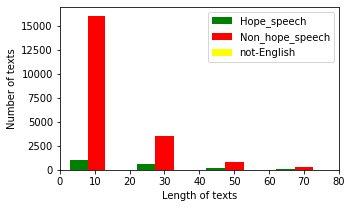

In [ ]:
comments_length_per_class(OH_X_train,'Training')

##Ktrain -BERT

1. [Text Classification Using Transformers](https://nbviewer.jupyter.org/github/amaiya/ktrain/blob/master/tutorials/tutorial-A3-hugging_face_transformers.ipynb)

2. [Related Article](https://towardsdatascience.com/text-classification-with-hugging-face-transformers-in-tensorflow-2-without-tears-ee50e4f3e7ed)

3. [Ktrain](https://github.com/amaiya/ktrain)

In [ ]:
pip install ktrain

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
import ktrain
from ktrain import text

In [ ]:
train_data['label'].value_counts()

Not_offensive                           14153
not-malayalam                            1287
Offensive_Targeted_Insult_Individual      239
Offensive_Untargetede                     191
Offensive_Targeted_Insult_Group           140
Name: label, dtype: int64

In [ ]:
valid_data['label'].value_counts()

Not_offensive                           1779
not-malayalam                            163
Offensive_Targeted_Insult_Individual      24
Offensive_Untargetede                     20
Offensive_Targeted_Insult_Group           13
Name: label, dtype: int64

In [ ]:
categories = ['Not_offensive',
       'Offensive_Targeted_Insult_Group',
       'Offensive_Targeted_Insult_Individual', 'Offensive_Untargetede',
       'not-malayalam']

In [ ]:
X_train = train_data['text'].tolist()
y_train = train_data['label'].tolist()

X_valid = valid_data['text'].tolist()
y_valid = valid_data['label'].tolist()

X_test = test_data['text'].tolist()
#y_test = test_data['label'].tolist()

In [ ]:
np.unique(y_train)

array(['Not_offensive', 'Offensive_Targeted_Insult_Group',
       'Offensive_Targeted_Insult_Individual', 'Offensive_Untargetede',
       'not-malayalam'], dtype='<U36')

In [ ]:
# 'bert-base-uncased'
# 'bert-base-multilingual-cased'
# 'distilbert-base-uncased'
# 'ai4bharat/indic-bert'
# 'albert-base-v2'
# 'xlm-roberta-base'
# 'xlnet-base-cased'


In [ ]:
model_name = 'bert-base-multilingual-cased'
trans = text.Transformer(model_name,maxlen=50,class_names=categories)

In [ ]:
train = trans.preprocess_train(X_train,y_train)
valid = trans.preprocess_test(X_valid,y_valid)
#test = trans.preprocess_test(X_test,y_test)


preprocessing train...
language: ml
train sequence lengths:
	mean : 9
	95percentile : 18
	99percentile : 31


Is Multi-Label? False
preprocessing test...
language: ml
test sequence lengths:
	mean : 9
	95percentile : 18
	99percentile : 34


In [ ]:
model = trans.get_classifier()

In [ ]:
learner = ktrain.get_learner(model, train_data=train,val_data=valid, batch_size=12)

In [ ]:
learner.lr_find(show_plot = True,max_epochs=10)

simulating training for different learning rates... this may take a few moments...


In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced'
                                               ,np.unique(y_train)
                                               ,y_train)



In [ ]:
learner.fit_onecycle(2e-5,15,class_weight=weight)  # 2e-5



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/15
1335/1335 [==============================] - 193s 130ms/step - loss: 1.4821 - accuracy: 0.1510 - val_loss: 1.3608 - val_accuracy: 0.3922
Epoch 2/15
1335/1335 [==============================] - 173s 127ms/step - loss: 1.1713 - accuracy: 0.4621 - val_loss: 1.0955 - val_accuracy: 0.6168
Epoch 3/15
1335/1335 [==============================] - 172s 127ms/step - loss: 0.8826 - accuracy: 0.5973 - val_loss: 1.2728 - val_accuracy: 0.4387
Epoch 4/15
1335/1335 [==============================] - 172s 127ms/step - loss: 0.6490 - accuracy: 0.6805 - val_loss: 0.8215 - val_accuracy: 0.7109
Epoch 5/15
1335/1335 [==============================] - 172s 127ms/step - loss: 0.4574 - accuracy: 0.7726 - val_loss: 0.7739 - val_accuracy: 0.7089
Epoch 6/15
1335/1335 [==============================] - 172s 127ms/step - loss: 0.3841 - accuracy: 0.8020 - val_loss: 0.3573 - val_accuracy: 0.8984
Epoch 7/15
1335/1335 [===========================

In [ ]:
learner.validate(class_names=categories)

                                      precision    recall  f1-score   support

                       Not_offensive       0.98      0.97      0.97      1779
     Offensive_Targeted_Insult_Group       0.53      0.62      0.57        13
Offensive_Targeted_Insult_Individual       0.61      0.58      0.60        24
               Offensive_Untargetede       0.46      0.60      0.52        20
                       not-malayalam       0.81      0.92      0.86       163

                            accuracy                           0.95      1999
                           macro avg       0.68      0.74      0.70      1999
                        weighted avg       0.95      0.95      0.95      1999



array([[1717,    6,    8,   13,   35],
       [   4,    8,    0,    1,    0],
       [  10,    0,   14,    0,    0],
       [   6,    1,    1,   12,    0],
       [  13,    0,    0,    0,  150]])

In [ ]:
learner.save_model(folder_path+'Transformers_Models'+'/ml_off_m-bert_cw_learner')
# train further here

In [ ]:
learner.load_model(folder_path+'Transformers_Models'+'/ml_off_xlm-r_learner')

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc=trans)

In [ ]:
# Save and load the model
#predictor.save(folder_path+'Transformers_Models'+'/ml_off_xlm-r_predictor')
#predictor = ktrain.load_predictor(folder_path+'Transformers_Models'+'/ml_xlm-r_predictor')

In [ ]:
y_pred = predictor.predict(X_test)
y_pred

In [ ]:
test_data['id'] = test_data.index+1

In [ ]:
run = pd.DataFrame(test_data['id'])
run['text'] = test_data['text']
run['label'] = y_pred
run

In [ ]:
run['label'].value_counts()

Not_offensive                           1588
not-malayalam                            239
Offensive_Targeted_Insult_Individual      84
Offensive_Untargetede                     63
Offensive_Targeted_Insult_Group           27
Name: label, dtype: int64

In [ ]:
run['label'].value_counts()

Not_offensive            1804
not-malayalam             161
Offensive_Untargetede      36
Name: label, dtype: int64

In [ ]:
run.to_csv(folder_path +'malayalam_off_m-bert_cw.csv',index = False)

In [ ]:
%%time
predictor = ktrain.load_predictor(folder_path+'Transformers_Models'+'/ml_off_indic-bert_cw_predictor')

CPU times: user 562 ms, sys: 80.6 ms, total: 642 ms
Wall time: 2.6 s


In [ ]:
vv = predictor.predict(X_valid)

In [ ]:
print(vv)

['Not_offensive', 'Not_offensive', 'Not_offensive', 'Not_offensive', 'Not_offensive', 'not-malayalam', 'Not_offensive', 'Not_offensive', 'Not_offensive', 'Not_offensive', 'Not_offensive', 'Not_offensive', 'Not_offensive', 'Not_offensive', 'Not_offensive', 'Not_offensive', 'Not_offensive', 'Not_offensive', 'Not_offensive', 'Not_offensive', 'Not_offensive', 'Not_offensive', 'Not_offensive', 'Not_offensive', 'Not_offensive', 'Not_offensive', 'Not_offensive', 'Not_offensive', 'Not_offensive', 'Not_offensive', 'Not_offensive', 'Not_offensive', 'not-malayalam', 'Not_offensive', 'Not_offensive', 'Not_offensive', 'Not_offensive', 'Not_offensive', 'Not_offensive', 'Not_offensive', 'Not_offensive', 'Not_offensive', 'not-malayalam', 'Not_offensive', 'Not_offensive', 'Not_offensive', 'not-malayalam', 'Not_offensive', 'Offensive_Targeted_Insult_Individual', 'Not_offensive', 'Not_offensive', 'Not_offensive', 'Not_offensive', 'Not_offensive', 'Not_offensive', 'not-malayalam', 'Not_offensive', 'Not_of

In [ ]:
tt = pd.DataFrame(valid_data.index+1, columns=['id']) 
tt['label']=vv
tt
tt.to_excel(folder_path+'ml_off_indic-bert_cw_predictor.xlsx', index= False)

In [ ]:
xlmr_val = pd.read_excel(folder_path+'off-ml-xlmr.xlsx')
indic_bert = pd.read_excel(folder_path+'ml_off_indic-bert_predictor.xlsx')
indic_bert_cw = pd.read_excel(folder_path+'ml_off_indic-bert_cw_predictor.xlsx')

In [ ]:
print(classification_report(valid_data['label'], xlmr_val['label']))
print(classification_report(valid_data['label'], indic_bert['label']))
print(classification_report(valid_data['label'], indic_bert_cw['label']))
print(classification_report(valid_data['label'], result['id4']))


                                      precision    recall  f1-score   support

                       Not_offensive       0.97      0.98      0.97      1779
     Offensive_Targeted_Insult_Group       0.00      0.00      0.00        13
Offensive_Targeted_Insult_Individual       0.00      0.00      0.00        24
               Offensive_Untargetede       0.32      0.60      0.42        20
                       not-malayalam       0.87      0.91      0.89       163

                            accuracy                           0.95      1999
                           macro avg       0.43      0.50      0.46      1999
                        weighted avg       0.94      0.95      0.94      1999

                                      precision    recall  f1-score   support

                       Not_offensive       0.98      0.93      0.96      1779
     Offensive_Targeted_Insult_Group       0.60      0.69      0.64        13
Offensive_Targeted_Insult_Individual       0.22      0.54   

In [ ]:
result = pd.DataFrame(columns=['id1', 'id2', 'id3'])
result['id1']=xlmr_val['label']
result['id2']=indic_bert['label']
result['id3'] =indic_bert_cw['label']
result['id4'] = result['id2']
result

,id1,id2,id3,id4
0,Not_offensive,Not_offensive,Not_offensive,Not_offensive
1,Not_offensive,Not_offensive,Not_offensive,Not_offensive
2,Not_offensive,Not_offensive,Not_offensive,Not_offensive
3,Not_offensive,Not_offensive,Not_offensive,Not_offensive
4,Not_offensive,Not_offensive,Not_offensive,Not_offensive
...,...,...,...,...
1994,Not_offensive,Not_offensive,Not_offensive,Not_offensive
1995,Not_offensive,Not_offensive,Not_offensive,Not_offensive
1996,Not_offensive,Not_offensive,Not_offensive,Not_offensive
1997,Not_offensive,Not_offensive,Not_offensive,Not_offensive


In [ ]:
c=0
for i in range(len(valid_data)):
   
    if (result['id1'][i]==result['id2'][i]):
        result['id4'][i] = result['id1'][i]
    elif(result['id1'][i]==result['id3'][i]):
        result['id4'][i] = result['id1'][i]
    elif(result['id2'][i]==result['id3'][i]):
         result['id4'][i] = result['id2'][i]

In [ ]:
result['id1'].value_counts()


Not_offensive            1792
not-malayalam             170
Offensive_Untargetede      37
Name: id1, dtype: int64

In [ ]:
result['id4'].value_counts()

Not_offensive                           1776
not-malayalam                            172
Offensive_Untargetede                     43
Offensive_Targeted_Insult_Individual       8
Name: id4, dtype: int64

In [ ]:
print(classification_report(valid_data['label'], result['id4']))

                                      precision    recall  f1-score   support

                       Not_offensive       0.98      0.97      0.97      1779
     Offensive_Targeted_Insult_Group       0.00      0.00      0.00        13
Offensive_Targeted_Insult_Individual       0.50      0.17      0.25        24
               Offensive_Untargetede       0.23      0.50      0.32        20
                       not-malayalam       0.85      0.90      0.88       163

                            accuracy                           0.95      1999
                           macro avg       0.51      0.51      0.48      1999
                        weighted avg       0.95      0.95      0.95      1999



##Machine Learning

In [ ]:
def print_metrices(true,pred):
    print(confusion_matrix(true,pred))
    print(classification_report(true,pred))
    print("Accuracy : ",accuracy_score(true,pred))
    print("Precison : ",precision_score(true,pred, average = 'weighted'))
    print("Recall : ",recall_score(true,pred,  average = 'weighted'))
    print("F1 : ",f1_score(true,pred,  average = 'weighted'))

In [ ]:
## TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
#use_idf=True,tokenizer=lambda x: x.split()
vectorizer = TfidfVectorizer(tokenizer=lambda x: x.split())
vectorised_posts = vectorizer.fit_transform(train_data['cleaned'])
vectorized_train_posts = vectorizer.transform(train_data['cleaned'])
vectorized_valid_posts = vectorizer.transform(valid_data['cleaned'])
vectorized_test_posts = vectorizer.transform(test_data['cleaned'])

print("Feature Size: ", vectorized_train_posts.shape[1])
#vectorizer.vocabulary_

Feature Size:  32597


In [ ]:
vectorized_valid_posts.shape

(2843, 20798)

In [ ]:
valid_data['label'].value_counts()

Not_offensive                           1779
not-malayalam                            163
Offensive_Targeted_Insult_Individual      24
Offensive_Untargetede                     20
Offensive_Targeted_Insult_Group           13
Name: label, dtype: int64

In [ ]:
labels = ['Not_offensive',
       'Offensive_Targeted_Insult_Group',
       'Offensive_Targeted_Insult_Individual', 'Offensive_Untargetede',
       'not-malayalam']
def actual_label(row):
    return labels[row]

### Logistic Regression

In [ ]:
# After Tunning
# Optimum C = 100 
lr = LogisticRegression(class_weight='balanced')
lr.fit(vectorized_train_posts,train_data['enc_label'])
y_pred = lr.predict(vectorized_valid_posts)
print_metrices(valid_data['enc_label'],y_pred)

[[1654   87    6   24    8]
 [  14  149    0    0    0]
 [  12    0   12    0    0]
 [   7    0    0   12    1]
 [   2    0    1    2    8]]
              precision    recall  f1-score   support

           0       0.98      0.93      0.95      1779
           1       0.63      0.91      0.75       163
           2       0.63      0.50      0.56        24
           3       0.32      0.60      0.41        20
           4       0.47      0.62      0.53        13

    accuracy                           0.92      1999
   macro avg       0.61      0.71      0.64      1999
weighted avg       0.94      0.92      0.92      1999

Accuracy :  0.9179589794897449
Precison :  0.936787063200354
Recall :  0.9179589794897449
F1 :  0.9240959319874745


In [ ]:
test_pred = lr.predict(vectorized_test_posts).tolist()
test_data['id'] = test_data.index + 1

In [ ]:
run = pd.DataFrame(test_data['id'])
run['text'] = test_data['text']
run['label'] = test_pred
run['label'] = run['label'].apply(actual_label)
run 

In [ ]:
run.to_csv(folder_path +'malayalam_off_lr.csv',index = False)

### SVM

In [ ]:
## SVM
from sklearn.svm import SVC
svc =  SVC(kernel='linear' ,random_state=1234,class_weight='balanced',C =5)
svc.fit(vectorized_train_posts,train_data['enc_label'])
y_pred = svc.predict(vectorized_valid_posts)
print_metrices(valid_data['enc_label'],y_pred)

[[1723   49    2    3    2]
 [  24  139    0    0    0]
 [  12    0   12    0    0]
 [   7    0    0   12    1]
 [   5    0    0    0    8]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1779
           1       0.74      0.85      0.79       163
           2       0.86      0.50      0.63        24
           3       0.80      0.60      0.69        20
           4       0.73      0.62      0.67        13

    accuracy                           0.95      1999
   macro avg       0.82      0.71      0.75      1999
weighted avg       0.95      0.95      0.95      1999

Accuracy :  0.9474737368684342
Precison :  0.9491371209710723
Recall :  0.9474737368684342
F1 :  0.9472343067128154


In [ ]:
test_pred = svc.predict(vectorized_test_posts).tolist()
test_data['id'] = test_data.index + 1

In [ ]:
run = pd.DataFrame(test_data['id'])
run['text'] = test_data['text']
run['label'] = test_pred
run['label'] = run['label'].apply(actual_label)
run 

,id,text,label
0,1,അപ്പൊ ഇതൊരൊന്നൊരാ മൊതലാണല്ലേ Suraj ആണ് നടൻ ന്...,Not_offensive
1,2,എന്ത് ഊള എഡിറ്റിംഗ് ആടോ ഇത് ഒരുമാതിരി vivo vid...,Not_offensive
2,3,Fefka ee padam release cheyyan samadhicho?,Not_offensive
3,4,അആഹാ.. സംഗീതം ജെക്‌സ് ബിജോയ് ആണ് അപ്പൊ പൊട്ടലു...,Not_offensive
4,5,Ravile thane views likes ethra ayyi enn nokan ...,Not_offensive
...,...,...,...
1996,1997,Swargatthil ninnu purathaakkappetta daivatthin...,Not_offensive
1997,1998,Ivide Palakkad Jayettan Fans club nnu ashamsak...,Not_offensive
1998,1999,ഈ പടത്തിന് വെയിറ്റ് ചെയ്യുന്ന മമ്മൂക്ക ഫാൻസും,Not_offensive
1999,2000,കട്ട ലാലേട്ടൻ ഫാൻസ് ഒരു ലൈക് തന്നിട്ട് പോവാമോ ...,Not_offensive


In [ ]:
run['label'].value_counts()

Not_offensive                           1757
Offensive_Targeted_Insult_Group          187
Offensive_Untargetede                     24
Offensive_Targeted_Insult_Individual      18
not-malayalam                             15
Name: label, dtype: int64

In [ ]:
run.to_csv(folder_path +'malayalam_off_svm.csv',index = False)

### Ensemble Appraoch (Majority Voting)

In [ ]:

LogReg_clf = LogisticRegression(class_weight='balanced')
DTree_clf = DecisionTreeClassifier(class_weight='balanced',)
rt_clf =   RandomForestClassifier(class_weight='balanced')
SVC_clf = SVC(C = 5,class_weight='balanced')


voting_clf = VotingClassifier(estimators=[('SVC', SVC_clf), ('DTree', DTree_clf), ('LogReg', LogReg_clf),('RF', rt_clf)], voting='hard')
voting_clf.fit(vectorized_train_posts, train_data['enc_label'])
preds = voting_clf.predict(vectorized_valid_posts)
print_metrices(valid_data['enc_label'], preds)


[[1765   12    1    0    1]
 [  36  127    0    0    0]
 [  12    0   12    0    0]
 [  10    0    0   10    0]
 [   6    0    0    0    7]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1779
           1       0.91      0.78      0.84       163
           2       0.92      0.50      0.65        24
           3       1.00      0.50      0.67        20
           4       0.88      0.54      0.67        13

    accuracy                           0.96      1999
   macro avg       0.94      0.66      0.76      1999
weighted avg       0.96      0.96      0.96      1999

Accuracy :  0.9609804902451226
Precison :  0.9600832884680645
Recall :  0.9609804902451226
F1 :  0.9580794139226035


In [ ]:
test_pred = voting_clf.predict(vectorized_test_posts).tolist()
test_data['id'] = test_data.index + 1

In [ ]:
run = pd.DataFrame(test_data['id'])
run['text'] = test_data['text']
run['label'] = test_pred
run['label'] = run['label'].apply(actual_label)
run 

,id,text,label
0,1,അപ്പൊ ഇതൊരൊന്നൊരാ മൊതലാണല്ലേ Suraj ആണ് നടൻ ന്...,Not_offensive
1,2,എന്ത് ഊള എഡിറ്റിംഗ് ആടോ ഇത് ഒരുമാതിരി vivo vid...,Not_offensive
2,3,Fefka ee padam release cheyyan samadhicho?,Not_offensive
3,4,അആഹാ.. സംഗീതം ജെക്‌സ് ബിജോയ് ആണ് അപ്പൊ പൊട്ടലു...,Not_offensive
4,5,Ravile thane views likes ethra ayyi enn nokan ...,Not_offensive
...,...,...,...
1996,1997,Swargatthil ninnu purathaakkappetta daivatthin...,Not_offensive
1997,1998,Ivide Palakkad Jayettan Fans club nnu ashamsak...,Not_offensive
1998,1999,ഈ പടത്തിന് വെയിറ്റ് ചെയ്യുന്ന മമ്മൂക്ക ഫാൻസും,Not_offensive
1999,2000,കട്ട ലാലേട്ടൻ ഫാൻസ് ഒരു ലൈക് തന്നിട്ട് പോവാമോ ...,Not_offensive


In [ ]:
run['label'].value_counts()

Not_offensive                           1825
Offensive_Targeted_Insult_Group          133
Offensive_Untargetede                     17
Offensive_Targeted_Insult_Individual      15
not-malayalam                             11
Name: label, dtype: int64

In [ ]:
run.to_csv(folder_path +'malayalam_off_voting.csv',index = False)

##Deep Learning

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import regularizers
from tensorflow.keras.layers import LSTM,GRU
from tensorflow.keras.models import load_model
print("Tensorflow Version:--",tf.version.VERSION)
print("Keras Version:---",keras.__version__)

Tensorflow Version:-- 2.4.0
Keras Version:--- 2.4.0


###Tokenization

In [ ]:
tokenizer = Tokenizer(num_words = 10000,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n-', 
                      split=' ', char_level=False, oov_token='<oov>', document_count=0)
tokenizer.fit_on_texts(train_data['text'])  
vocab_size = len(tokenizer.word_index)+1

In [ ]:
print(vocab_size)

31746


In [ ]:
max_len = 50
# Training Sequences
train_sequences = tokenizer.texts_to_sequences(train_data['text'])
print(len(tokenizer.word_index))
train_pad_sequences =  keras.preprocessing.sequence.pad_sequences(train_sequences, value=0.0, padding='post', maxlen= max_len)
print("Number of Training Sequences :" ,train_pad_sequences.shape)

# Validation Sequences
validation_sequences = tokenizer.texts_to_sequences(valid_data['text'])
validation_pad_sequences =  keras.preprocessing.sequence.pad_sequences(validation_sequences, value=0.0, padding='post', maxlen= max_len)
print("Number of Validation Sequences :" ,validation_pad_sequences.shape)

31745
Number of Training Sequences : (16010, 50)
Number of Validation Sequences : (1999, 50)


In [ ]:
# Test Sequences
test_sequences = tokenizer.texts_to_sequences(test_data['text'])
test_pad_sequences =  keras.preprocessing.sequence.pad_sequences(test_sequences, value=0.0, padding='post', maxlen= max_len)
print("Number of Test Sequences :" ,test_pad_sequences.shape)

Number of Test Sequences : (2001, 50)


In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced'
                                               ,np.unique(train_data['enc_label'])
                                               ,train_data['enc_label'])

weight = {i : class_weights[i] for i in range(5)}

In [ ]:
weight

{0: 0.22624178619373983,
 1: 2.487956487956488,
 2: 13.397489539748953,
 3: 16.76439790575916,
 4: 22.87142857142857}

In [ ]:
num_classes = 5

accuracy_threshold = 0.99

class myCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
      if(logs.get('accuracy')>accuracy_threshold):
        print("\nReached %2.2f%% accuracy so we will stop trianing" % (accuracy_threshold*100))
        self.model.stop_training = True

acc_callback = myCallback()
# Saved the Best Model
filepath = folder_path+"ml_off_BiLSTMModel.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True, 
                                             save_weights_only=False, mode='max')
# callback list
callback_list = [acc_callback, checkpoint] 
model = tf.keras.models.Sequential([
tf.keras.layers.Embedding(10000, 100, input_length = max_len),
tf.keras.layers.Conv1D(128, 5, activation='relu'),
tf.keras.layers.MaxPooling1D(5),
tf.keras.layers.Bidirectional(LSTM(units = 32,return_sequences=True,dropout = 0.2)),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(5 , activation='softmax')])

model.summary()


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 50, 100)           1000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 46, 128)           64128     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 9, 128)            0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, 9, 64)             41216     
_________________________________________________________________
flatten_8 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 2885      
Total params: 1,108,229
Trainable params: 1,108,229
Non-trainable params: 0
____________________________________________

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])
   
history = model.fit(train_pad_sequences,
    train_data['enc_label'],
    epochs=15,
    batch_size = 32,
    validation_split = 0.2,
    verbose =1,
    callbacks = callback_list,
    class_weight = weight)

Epoch 1/15
401/401 [==============================] - 8s 12ms/step - loss: 1.4113 - accuracy: 0.2546 - val_loss: 1.1415 - val_accuracy: 0.5999

Epoch 00001: val_accuracy improved from -inf to 0.59994, saving model to /content/drive/MyDrive/Colab Notebooks/NLP Projects/EACL 2021- Shared Tasks/Offensive Language/ml_off_BiLSTMModel.h5
Epoch 2/15
401/401 [==============================] - 4s 10ms/step - loss: 0.7912 - accuracy: 0.8119 - val_loss: 0.6015 - val_accuracy: 0.8051

Epoch 00002: val_accuracy improved from 0.59994 to 0.80512, saving model to /content/drive/MyDrive/Colab Notebooks/NLP Projects/EACL 2021- Shared Tasks/Offensive Language/ml_off_BiLSTMModel.h5
Epoch 3/15
401/401 [==============================] - 4s 10ms/step - loss: 0.3511 - accuracy: 0.9070 - val_loss: 0.5352 - val_accuracy: 0.8345

Epoch 00003: val_accuracy improved from 0.80512 to 0.83448, saving model to /content/drive/MyDrive/Colab Notebooks/NLP Projects/EACL 2021- Shared Tasks/Offensive Language/ml_off_BiLSTMM

In [ ]:
# Load the saved model
model = load_model(folder_path+'ml_off_BiLSTMModel.h5')
# prediction
y_pred = np.argmax(model.predict(validation_pad_sequences), axis=-1)
print_metrices(valid_data['enc_label'],y_pred)


[[1676   53   23    8   19]
 [  31  127    0    0    5]
 [  10    1   12    0    1]
 [  10    0    1    8    1]
 [   3    0    0    2    8]]
              precision    recall  f1-score   support

           0       0.97      0.94      0.96      1779
           1       0.70      0.78      0.74       163
           2       0.33      0.50      0.40        24
           3       0.44      0.40      0.42        20
           4       0.24      0.62      0.34        13

    accuracy                           0.92      1999
   macro avg       0.54      0.65      0.57      1999
weighted avg       0.93      0.92      0.92      1999

Accuracy :  0.9159579789894947
Precison :  0.929358878637004
Recall :  0.9159579789894947
F1 :  0.9215633088849647


### Test Set Prediction

In [ ]:
test_pred = np.argmax(model.predict(test_pad_sequences), axis=-1).tolist()


In [ ]:
test_data['id'] = test_data.index + 1
run = pd.DataFrame(test_data['id'])
run['text'] = test_data['text']
run['label'] = test_pred
run['label'] = run['label'].apply(actual_label)
run 

,id,text,label
0,1,അപ്പൊ ഇതൊരൊന്നൊരാ മൊതലാണല്ലേ Suraj ആണ് നടൻ ന്...,Not_offensive
1,2,എന്ത് ഊള എഡിറ്റിംഗ് ആടോ ഇത് ഒരുമാതിരി vivo vid...,Not_offensive
2,3,Fefka ee padam release cheyyan samadhicho?,Offensive_Targeted_Insult_Individual
3,4,അആഹാ.. സംഗീതം ജെക്‌സ് ബിജോയ് ആണ് അപ്പൊ പൊട്ടലു...,Not_offensive
4,5,Ravile thane views likes ethra ayyi enn nokan ...,Not_offensive
...,...,...,...
1996,1997,Swargatthil ninnu purathaakkappetta daivatthin...,Not_offensive
1997,1998,Ivide Palakkad Jayettan Fans club nnu ashamsak...,Not_offensive
1998,1999,ഈ പടത്തിന് വെയിറ്റ് ചെയ്യുന്ന മമ്മൂക്ക ഫാൻസും,Not_offensive
1999,2000,കട്ട ലാലേട്ടൻ ഫാൻസ് ഒരു ലൈക് തന്നിട്ട് പോവാമോ ...,Not_offensive


In [ ]:
run.to_csv(folder_path +'malayalam_off_cnn+bilstm.csv',index = False)

##Pretrained Word Embedding (Fasttext)

In [ ]:
from urllib.request import urlopen
import gzip

# get the vectors
file = gzip.open(urlopen('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ml.300.vec.gz'))

In [ ]:
tokenizer = Tokenizer(num_words = 40000,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n-', 
                      split=' ', char_level=False, oov_token='<oov>', document_count=0)
tokenizer.fit_on_texts(train_data['text'])  
word_index = tokenizer.word_index
vocab_size = len(word_index )+1

In [ ]:
vocab_and_vectors = {}
# put words as dict indexes and vectors as words values
for line in file:
  values = line.split()
  word = values [0].decode('utf-8')
  vector = np.asarray(values[1:], dtype='float32')
  vocab_and_vectors[word] = vector

In [ ]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in word_index.items():
  embedding_vector = vocab_and_vectors.get(word)
  # words that cannot be found will be set to 0
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [ ]:
max_len = 50
# Training Sequences
train_sequences = tokenizer.texts_to_sequences(train_data['text'])
print(len(tokenizer.word_index))
train_pad_sequences =  keras.preprocessing.sequence.pad_sequences(train_sequences, value=0.0, padding='post', maxlen= max_len)
print("Number of Training Sequences :" ,train_pad_sequences.shape)

# Validation Sequences
validation_sequences = tokenizer.texts_to_sequences(valid_data['text'])
validation_pad_sequences =  keras.preprocessing.sequence.pad_sequences(validation_sequences, value=0.0, padding='post', maxlen= max_len)
print("Number of Validation Sequences :" ,validation_pad_sequences.shape)

31745
Number of Training Sequences : (16010, 50)
Number of Validation Sequences : (1999, 50)


In [ ]:
# Test Sequences
test_sequences = tokenizer.texts_to_sequences(test_data['text'])
test_pad_sequences =  keras.preprocessing.sequence.pad_sequences(test_sequences, value=0.0, padding='post', maxlen= max_len)
print("Number of Test Sequences :" ,test_pad_sequences.shape)

Number of Test Sequences : (2001, 50)


In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced'
                                               ,np.unique(train_data['enc_label'])
                                               ,train_data['enc_label'])

weight = {i : class_weights[i] for i in range(5)}

#### Model Defination

In [ ]:
num_classes = 5

accuracy_threshold = 0.99

class myCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
      if(logs.get('accuracy')>accuracy_threshold):
        print("\nReached %2.2f%% accuracy so we will stop trianing" % (accuracy_threshold*100))
        self.model.stop_training = True

acc_callback = myCallback()
# Saved the Best Model
filepath = folder_path+"prt_ml_off_BiLSTMModel.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True, 
                                             save_weights_only=False, mode='max')
# callback list
callback_list = [acc_callback, checkpoint] 
model = tf.keras.models.Sequential([
tf.keras.layers.Embedding(vocab_size, 300,weights=[embedding_matrix],trainable=False, input_length = max_len),
tf.keras.layers.Conv1D(128, 5, activation='relu'),
tf.keras.layers.MaxPooling1D(5),
tf.keras.layers.Bidirectional(LSTM(units = 128,return_sequences=True,dropout = 0.2)),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(5, activation='softmax')])

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 300)           9523800   
_________________________________________________________________
conv1d (Conv1D)              (None, 46, 128)           192128    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 9, 128)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 9, 256)            263168    
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 11525     
Total params: 9,990,621
Trainable params: 466,821
Non-trainable params: 9,523,800
________________________________________

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])
   
history = model.fit(train_pad_sequences,
    train_data['enc_label'],
    epochs=200,
    batch_size = 32,
    validation_split = 0.2,
    verbose =1,
    callbacks = callback_list,
    class_weight = weight)

Epoch 1/200
401/401 [==============================] - 15s 12ms/step - loss: 1.4598 - accuracy: 0.2291 - val_loss: 1.3354 - val_accuracy: 0.3773

Epoch 00001: val_accuracy improved from -inf to 0.37726, saving model to /content/drive/MyDrive/Colab Notebooks/NLP Projects/EACL 2021- Shared Tasks/Offensive Language/prt_ml_off_BiLSTMModel.h5
Epoch 2/200
401/401 [==============================] - 4s 9ms/step - loss: 1.1580 - accuracy: 0.4677 - val_loss: 0.8681 - val_accuracy: 0.6861

Epoch 00002: val_accuracy improved from 0.37726 to 0.68613, saving model to /content/drive/MyDrive/Colab Notebooks/NLP Projects/EACL 2021- Shared Tasks/Offensive Language/prt_ml_off_BiLSTMModel.h5
Epoch 3/200
401/401 [==============================] - 4s 9ms/step - loss: 0.8581 - accuracy: 0.5510 - val_loss: 0.9560 - val_accuracy: 0.6109

Epoch 00003: val_accuracy did not improve from 0.68613
Epoch 4/200
401/401 [==============================] - 4s 9ms/step - loss: 0.5573 - accuracy: 0.6254 - val_loss: 0.8880 

In [ ]:
# Load the saved model
model = load_model(folder_path+'prt_ml_off_BiLSTMModel.h5')
# prediction
y_pred = np.argmax(model.predict(validation_pad_sequences), axis=-1)
print_metrices(valid_data['enc_label'],y_pred)


[[1705   48   13    9    4]
 [  30  131    0    0    2]
 [  11    0   13    0    0]
 [  13    0    1    6    0]
 [   7    0    0    0    6]]
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      1779
           1       0.73      0.80      0.77       163
           2       0.48      0.54      0.51        24
           3       0.40      0.30      0.34        20
           4       0.50      0.46      0.48        13

    accuracy                           0.93      1999
   macro avg       0.62      0.61      0.61      1999
weighted avg       0.93      0.93      0.93      1999

Accuracy :  0.9309654827413707
Precison :  0.9319144677219902
Recall :  0.9309654827413707
F1 :  0.9311937219955937


In [ ]:
test_pred = np.argmax(model.predict(test_pad_sequences), axis=-1).tolist()


In [ ]:
test_data['id'] = test_data.index + 1
run = pd.DataFrame(test_data['id'])
run['text'] = test_data['text']
run['label'] = test_pred
run['label'] = run['label'].apply(actual_label)
run 


In [ ]:
run.to_csv(folder_path + 'malayalam_off_cnn+bilstm+fasttext.csv',index = False)

## Attention

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Concatenate, Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Flatten
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Convolution1D
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.layers import Add, BatchNormalization, Activation, Dropout

In [ ]:
MAX_FEATURES = 10000
EMBED_SIZE = 128
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(train_data['cleaned'])
list_tokenized_train = tokenizer.texts_to_sequences(train_data['cleaned'])
list_tokenized_val = tokenizer.texts_to_sequences(valid_data['cleaned'])  
list_tokenized_test = tokenizer.texts_to_sequences(test_data['cleaned'])  
RNN_CELL_SIZE = 100
  
MAX_LEN = 200  
X_train = pad_sequences(list_tokenized_train, maxlen=MAX_LEN)
y_train = train_data['enc_label']
X_val = pad_sequences(list_tokenized_val, maxlen=MAX_LEN)
y_val = valid_data['enc_label']
X_test = pad_sequences(list_tokenized_test, maxlen=MAX_LEN)

In [ ]:
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
          
        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = tf.nn.tanh(
            self.W1(features) + self.W2(hidden_with_time_axis))
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
          
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

In [ ]:
sequence_input = Input(shape=(MAX_LEN,), dtype="int32")
embedded_sequences = Embedding(MAX_FEATURES, EMBED_SIZE)(sequence_input)

In [ ]:
#conv = Convolution1D(128,5,activation='relu')(embedded_sequences)
#pol = GlobalMaxPool1D()(conv)

lstm = Bidirectional(LSTM(64, return_sequences = True), name="bi_lstm_0")(embedded_sequences)

# Getting our LSTM outputs
(lstm, forward_h, forward_c, backward_h, backward_c) = Bidirectional(LSTM(64, return_sequences=True, return_state=True), name="bi_lstm_1")(lstm)

In [ ]:
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
context_vector, attention_weights = Attention(20)(lstm, state_h)
dense1 = Dense(20, activation="relu")(context_vector)
dropout = Dropout(0.1)(dense1)
output = Dense(6, activation="softmax")(dropout)
  
model = keras.Model(inputs=sequence_input, outputs=output)

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer= keras.optimizers.Adam(learning_rate = 0.001),
              metrics=['accuracy'])

In [ ]:
BATCH_SIZE = 64
EPOCHS = 6
history = model.fit(X_train,y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.10)

Epoch 1/6
226/226 [==============================] - 22s 67ms/step - loss: 0.6966 - accuracy: 0.8489 - val_loss: 0.3314 - val_accuracy: 0.9107
Epoch 2/6
226/226 [==============================] - 13s 56ms/step - loss: 0.2657 - accuracy: 0.9311 - val_loss: 0.3315 - val_accuracy: 0.9225
Epoch 3/6
226/226 [==============================] - 13s 56ms/step - loss: 0.1868 - accuracy: 0.9453 - val_loss: 0.2832 - val_accuracy: 0.9257
Epoch 4/6
226/226 [==============================] - 13s 56ms/step - loss: 0.1140 - accuracy: 0.9614 - val_loss: 0.2758 - val_accuracy: 0.9313
Epoch 5/6
226/226 [==============================] - 13s 56ms/step - loss: 0.0878 - accuracy: 0.9685 - val_loss: 0.3018 - val_accuracy: 0.9300
Epoch 6/6
226/226 [==============================] - 13s 57ms/step - loss: 0.0851 - accuracy: 0.9703 - val_loss: 0.3172 - val_accuracy: 0.9307


In [ ]:
prediction = np.argmax(model.predict(X_val),axis = -1)
print_metrices(valid_data['enc_label'],prediction)

[[1715   35   14    8    7]
 [  46  117    0    0    0]
 [  12    0   10    2    0]
 [   9    0    5    5    1]
 [   2    0    1    3    7]]
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1779
           1       0.77      0.72      0.74       163
           2       0.33      0.42      0.37        24
           3       0.28      0.25      0.26        20
           4       0.47      0.54      0.50        13

    accuracy                           0.93      1999
   macro avg       0.56      0.58      0.57      1999
weighted avg       0.93      0.93      0.93      1999

Accuracy :  0.927463731865933
Precison :  0.9281054092724383
Recall :  0.927463731865933
F1 :  0.9276293553302132


In [ ]:
test_pred = np.argmax(model.predict(X_test), axis=-1).tolist()
test_data['id'] = test_data.index + 1
run = pd.DataFrame(test_data['id'])
run['text'] = test_data['text']
run['label'] = test_pred
run['label'] = run['label'].apply(actual_label)
run 

,id,text,label
0,1,അപ്പൊ ഇതൊരൊന്നൊരാ മൊതലാണല്ലേ Suraj ആണ് നടൻ ന്...,Not_offensive
1,2,എന്ത് ഊള എഡിറ്റിംഗ് ആടോ ഇത് ഒരുമാതിരി vivo vid...,Not_offensive
2,3,Fefka ee padam release cheyyan samadhicho?,Offensive_Targeted_Insult_Individual
3,4,അആഹാ.. സംഗീതം ജെക്‌സ് ബിജോയ് ആണ് അപ്പൊ പൊട്ടലു...,Not_offensive
4,5,Ravile thane views likes ethra ayyi enn nokan ...,Not_offensive
...,...,...,...
1996,1997,Swargatthil ninnu purathaakkappetta daivatthin...,Not_offensive
1997,1998,Ivide Palakkad Jayettan Fans club nnu ashamsak...,Not_offensive
1998,1999,ഈ പടത്തിന് വെയിറ്റ് ചെയ്യുന്ന മമ്മൂക്ക ഫാൻസും,Not_offensive
1999,2000,കട്ട ലാലേട്ടൻ ഫാൻസ് ഒരു ലൈക് തന്നിട്ട് പോവാമോ ...,Not_offensive


In [ ]:
run.to_csv(folder_path +'NLP@CUET_malayalam-10.csv',index = False)

# Kannada Dataset 

In [ ]:
%%time
train_data = pd.read_csv(dataset_path + "kannada_offensive_train.csv",delimiter='\t',header = None)
valid_data = pd.read_csv(dataset_path + "kannada_offensive_dev.csv",delimiter='\t',header = None)
test_data = pd.read_csv(dataset_path + "kannada_offensive_test.csv",delimiter='\t',header = None)

CPU times: user 20.7 ms, sys: 784 µs, total: 21.5 ms
Wall time: 1.26 s


In [ ]:
train_data = train_data.rename(columns={0:'text',1:'label'})
valid_data = valid_data.rename(columns={0:'text',1:'label'})
test_data = test_data.rename(columns={0:'text'})

In [ ]:
train_data['label'].value_counts()

Not_offensive                           3544
not-Kannada                             1522
Offensive_Targeted_Insult_Individual     487
Offensive_Targeted_Insult_Group          329
Offensive_Untargetede                    212
Offensive_Targeted_Insult_Other          123
Name: label, dtype: int64

In [ ]:
valid_data['label'].value_counts()

Not_offensive                           426
not-Kannada                             191
Offensive_Targeted_Insult_Individual     66
Offensive_Targeted_Insult_Group          45
Offensive_Untargetede                    33
Offensive_Targeted_Insult_Other          16
Name: label, dtype: int64

In [ ]:
train_data['enc_label'] = train_data['label'].replace({'Not_offensive':0, 'not-Kannada':1,'Offensive_Targeted_Insult_Individual':2
                                                       ,'Offensive_Untargetede':3,'Offensive_Targeted_Insult_Group':4,
                                                       'Offensive_Targeted_Insult_Other':5
                                                       })
valid_data['enc_label'] = valid_data['label'].replace({'Not_offensive':0, 'not-Kannada':1,'Offensive_Targeted_Insult_Individual':2
                                                       ,'Offensive_Untargetede':3,'Offensive_Targeted_Insult_Group':4,
                                                       'Offensive_Targeted_Insult_Other':5
                                                       })

In [ ]:
train_data

In [ ]:
train_data['text'].tolist()

In [ ]:
train_data['enc_label'].value_counts()

0    3544
1    1522
2     487
4     329
3     212
5     123
Name: enc_label, dtype: int64

In [ ]:
valid_data['enc_label'].value_counts()

0    426
1    191
2     66
4     45
3     33
5     16
Name: enc_label, dtype: int64

In [ ]:
print("Size of the training data ==> ", train_data.shape)
print("Size of the validation data ==>", valid_data.shape)
print("Size of the Test data ==>", test_data.shape)

Size of the training data ==>  (6217, 3)
Size of the validation data ==> (777, 3)
Size of the Test data ==> (778, 1)


## One Hot Encoding

In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

In [ ]:
encoder=OneHotEncoder(sparse=False)

encoded_labels = pd.DataFrame (encoder.fit_transform(train_data[['label']]))

encoded_labels .columns = encoder.get_feature_names(['label'])

train_data= pd.concat([train_data, encoded_labels ], axis=1)

In [ ]:
train_data = train_data.rename(columns={'label_Not_offensive':'Not_offensive','label_Offensive_Targeted_Insult_Group':'Offensive_Targeted_Insult_Group',
                                        'label_Offensive_Targeted_Insult_Individual':'Offensive_Targeted_Insult_Individual',
                                        'label_Offensive_Targeted_Insult_Other':'Offensive_Targeted_Insult_Other',
                                        'label_Offensive_Untargetede':'Offensive_Untargetede',
                                        'label_not-Kannada':'not-Kannada'})
train_data

## Cleaning

In [ ]:
'''
Text Cleaning
'''
def text_cleaning(row):
  # to remove HTML tags
  text = BeautifulSoup(row, 'html.parser').get_text()
  d = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE) #This line is for removing url
  post = d.replace('\n', '')
  post = post.replace('—', ' ')
  # to remove accented characters
  new_text = unicodedata.normalize('NFKD', post).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  # to remove special characters and numbers
  # define the pattern to keep
  #pat = r'[^a-zA-z0-9.,!?/:;\"\'\s]' 
  #text = re.sub(pat, '', new_text)
  #to remove punctuation
  text = ''.join([c for c in text if c not in string.punctuation])
  # to remove special characters
  pattern = r'^\s*|\s\s*'
  text = re.sub(pattern, ' ', text).strip()
  # convert into lower case
  text = text.lower() 
  # Stopword Removing
  tokenizer = ToktokTokenizer()
  # convert sentence into token of words
  tokens = tokenizer.tokenize(text)
  tokens = [token.strip() for token in tokens]
  # check in lowercase 
  #t = [token for token in tokens if token.lower() not in stopword_list]
  #text = ' '.join(t) 
  # Stemming
  #t = [stemming.stem(token) for token in tokens ]
  #text = ' '.join(t) 

  return text



In [ ]:
#removing URLs and Punctuations
#train_data['cleaned'] = train_data['tweet'].apply(remove_url)
#Removing punctuations
train_data['cleaned'] = train_data['text'].apply(text_cleaning)
valid_data['cleaned'] = valid_data['text'].apply(text_cleaning)
test_data['cleaned'] = test_data['text'].apply(text_cleaning)


## Data samples after cleaning
print("Data samples after cleaning:\n")
for i in range(10):
  print("Original Data:===\n",train_data.text[i],"\nCleaned Data:===\n",train_data.cleaned[i],)

In [ ]:
valid_data['cleaned'].shape

(2843,)

## Data Statistics

In [ ]:
train_data.columns

Index(['text', 'label', 'enc_label', 'cleaned', 'Not_offensive',
       'Offensive_Targeted_Insult_Group',
       'Offensive_Targeted_Insult_Individual',
       'Offensive_Targeted_Insult_Other', 'Offensive_Untargetede',
       'not-Kannada'],
      dtype='object')

In [ ]:
def char_length(row):
    return len(row.split())

In [ ]:
lables = ['Not_offensive',
       'Offensive_Targeted_Insult_Group',
       'Offensive_Targeted_Insult_Individual',
       'Offensive_Targeted_Insult_Other', 'Offensive_Untargetede',
       'not-Kannada']

# Count number of unique words in each set
def dataset_statistics(dataset):
  for l in lables:
    word_list = [word.strip() for t in list(dataset[dataset[l]==1.0].cleaned) for word in t.strip().split()]
    print(f"\nClass Name:--> {l} ") 
    print("Number of Words:{}".format(len(word_list))) 
    print("Number of Unique Words:{}".format(len(np.unique(word_list)))) 
    print("Maximum post length: {}".format(max(dataset[dataset[l]==1.0].cleaned.apply(char_length))))
    print("Average Words in texts: {}".format(np.mean(dataset[dataset[l]==1.0].cleaned.apply(char_length))))
    

In [ ]:
dataset_statistics(train_data)


Class Name:--> Not_offensive 
Number of Words:27880
Number of Unique Words:10299
Maximum post length: 96
Average Words in texts: 7.866817155756208

Class Name:--> Offensive_Targeted_Insult_Group 
Number of Words:4334
Number of Unique Words:2707
Maximum post length: 92
Average Words in texts: 13.173252279635259

Class Name:--> Offensive_Targeted_Insult_Individual 
Number of Words:5706
Number of Unique Words:3051
Maximum post length: 64
Average Words in texts: 11.716632443531827

Class Name:--> Offensive_Targeted_Insult_Other 
Number of Words:1380
Number of Unique Words:1012
Maximum post length: 39
Average Words in texts: 11.21951219512195

Class Name:--> Offensive_Untargetede 
Number of Words:2190
Number of Unique Words:1553
Maximum post length: 78
Average Words in texts: 10.330188679245284

Class Name:--> not-Kannada 
Number of Words:6492
Number of Unique Words:2169
Maximum post length: 82
Average Words in texts: 4.265440210249672


## Tweets length per class

In [ ]:
def comments_length_per_class(dataset,set_name):
  label = dataset[['Not_offensive',
       'Offensive_Targeted_Insult_Group',
       'Offensive_Targeted_Insult_Individual',
       'Offensive_Targeted_Insult_Other', 'Offensive_Untargetede',
       'not-Kannada']]
  label = label.values
  comment = dataset['cleaned']
  comment = comment.values
  y = np.zeros(label.shape)
  for ix in range(comment.shape[0]):
      l = len(comment[ix].split())
      if label[ix][0] :
          y[ix][0] = l
      if label[ix][1] :
          y[ix][1] = l
  #color = ['red','green','blue','yellow','chartreuse'] 
  labelsplt = ['Not_offensive',
       'Offensive_Targeted_Insult_Group',
       'Offensive_Targeted_Insult_Individual',
       'Offensive_Targeted_Insult_Other', 'Offensive_Untargetede',
       'not-Kannada']
  color = ['green','red','yellow']    
  bins = [1,20,40,60,80]   
  plt.figure(figsize=(5,3)) 
  #plt.title ('Tweets Length Distribution Per Class')
  plt.hist(y,bins = bins,label = labelsplt,color = color)
  plt.axis([0, 80, 0, 17000])
  plt.xlabel('Length of texts')
  plt.ylabel('Number of texts') 
  plt.legend()
  #plt.savefig(path+'real-fake_no_title.png',dpi = 600,bbox_inches ='tight')
  #plt.grid(True)
  plt.show()

##Ktrain -BERT

1. [Text Classification Using Transformers](https://nbviewer.jupyter.org/github/amaiya/ktrain/blob/master/tutorials/tutorial-A3-hugging_face_transformers.ipynb)

2. [Related Article](https://towardsdatascience.com/text-classification-with-hugging-face-transformers-in-tensorflow-2-without-tears-ee50e4f3e7ed)

3. [Ktrain](https://github.com/amaiya/ktrain)

In [ ]:
pip install ktrain

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
import ktrain
from ktrain import text

In [ ]:
train_data['label'].value_counts()

NameError: ignored

In [ ]:
valid_data['label'].value_counts()

Not_offensive                           426
not-Kannada                             191
Offensive_Targeted_Insult_Individual     66
Offensive_Targeted_Insult_Group          45
Offensive_Untargetede                    33
Offensive_Targeted_Insult_Other          16
Name: label, dtype: int64

In [ ]:
categories = ['Not_offensive',
       'Offensive_Targeted_Insult_Group',
       'Offensive_Targeted_Insult_Individual',
       'Offensive_Targeted_Insult_Other', 'Offensive_Untargetede',
       'not-Kannada']

In [ ]:
X_train = train_data['text'].tolist()
y_train = train_data['label'].tolist()

X_valid = valid_data['text'].tolist()
y_valid = valid_data['label'].tolist()

X_test = test_data['text'].tolist()
#y_test = test_data['label'].tolist()

In [ ]:
# 'bert-base-uncased'
# 'bert-base-multilingual-cased'
# 'distilbert-base-uncased'
# 'ai4bharat/indic-bert'
# 'albert-base-v2'
# 'xlm-roberta-base'
# 'xlnet-base-cased'


In [ ]:
model_name = 'xlm-roberta-base'
trans = text.Transformer(model_name,maxlen=50,class_names=categories)

In [ ]:
train = trans.preprocess_train(X_train,y_train)
valid = trans.preprocess_test(X_valid,y_valid)
#test = trans.preprocess_test(X_test,y_test)


preprocessing train...
language: kn
train sequence lengths:
	mean : 8
	95percentile : 21
	99percentile : 41


Is Multi-Label? False
preprocessing test...
language: kn
test sequence lengths:
	mean : 8
	95percentile : 22
	99percentile : 44


In [ ]:
model = trans.get_classifier()

In [ ]:
learner = ktrain.get_learner(model, train_data=train,val_data=valid, batch_size=12)

In [ ]:
learner.lr_find(show_plot = True,max_epochs=10)

simulating training for different learning rates... this may take a few moments...


In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced'
                                               ,np.unique(train_data['label'])
                                               ,train_data['label'])

weight = {i : class_weights[i] for i in range(6)}
weight

{0: 0.29237208427389016,
 1: 3.1494427558257345,
 2: 2.1276522929500343,
 3: 8.424119241192411,
 4: 4.887578616352202,
 5: 0.6807928164695576}

In [ ]:
learner.fit_onecycle(2e-5,20,class_weight = weight)  # 2e-5



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/20
519/519 [==============================] - 114s 171ms/step - loss: 1.7932 - accuracy: 0.1614 - val_loss: 1.6681 - val_accuracy: 0.3423
Epoch 2/20
519/519 [==============================] - 87s 164ms/step - loss: 1.6700 - accuracy: 0.3501 - val_loss: 1.6074 - val_accuracy: 0.3372
Epoch 3/20
519/519 [==============================] - 86s 163ms/step - loss: 1.5063 - accuracy: 0.4221 - val_loss: 1.4388 - val_accuracy: 0.4234
Epoch 4/20
519/519 [==============================] - 86s 163ms/step - loss: 1.4264 - accuracy: 0.4492 - val_loss: 1.2515 - val_accuracy: 0.5405
Epoch 5/20
519/519 [==============================] - 87s 164ms/step - loss: 1.4001 - accuracy: 0.5055 - val_loss: 1.2456 - val_accuracy: 0.5367
Epoch 6/20
519/519 [==============================] - 86s 163ms/step - loss: 1.3521 - accuracy: 0.5231 - val_loss: 1.0869 - val_accuracy: 0.5920
Epoch 7/20
519/519 [==============================] - 86s 163ms/st

In [ ]:
learner.validate(class_names=categories)

                                      precision    recall  f1-score   support

                       Not_offensive       0.81      0.71      0.76       426
     Offensive_Targeted_Insult_Group       0.38      0.33      0.35        45
Offensive_Targeted_Insult_Individual       0.52      0.67      0.59        66
     Offensive_Targeted_Insult_Other       0.09      0.06      0.07        16
               Offensive_Untargetede       0.18      0.15      0.16        33
                         not-Kannada       0.68      0.85      0.76       191

                            accuracy                           0.68       777
                           macro avg       0.44      0.46      0.45       777
                        weighted avg       0.69      0.68      0.68       777



array([[303,  17,  24,   5,  13,  64],
       [ 14,  15,   6,   3,   4,   3],
       [ 13,   3,  44,   0,   2,   4],
       [  8,   2,   2,   1,   2,   1],
       [ 14,   2,   6,   2,   5,   4],
       [ 23,   1,   2,   0,   2, 163]])

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc=trans)

In [ ]:
# Save and load the model
predictor.save(folder_path+'Transformers_Models'+'/ta_indic-bert_predictor')

In [ ]:
predictor = ktrain.load_predictor(folder_path+'Transformers_Models'+'/ta_xlm-r_predictor')

In [ ]:
y_pred = predictor.predict(X_test)
y_pred

In [ ]:
test_data['id'] = test_data.index+1

In [ ]:
run = pd.DataFrame(test_data['id'])
run['text'] = test_data['text']
run['label'] = y_pred
run

In [ ]:
run['label'].value_counts()

Not_offensive                           379
not-Kannada                             230
Offensive_Targeted_Insult_Individual     82
Offensive_Targeted_Insult_Group          48
Offensive_Untargetede                    32
Offensive_Targeted_Insult_Other           7
Name: label, dtype: int64

In [ ]:
run['label'].value_counts()

Non_hope_speech    1043
Hope_speech         615
not-Tamil           362
Name: label, dtype: int64

In [ ]:
run.to_csv(folder_path +'kannada_off_xlm-r_cw.csv',index = False)

##Machine Learning

In [ ]:
def print_metrices(true,pred):
    print(confusion_matrix(true,pred))
    print(classification_report(true,pred))
    print("Accuracy : ",accuracy_score(true,pred))
    print("Precison : ",precision_score(true,pred, average = 'weighted'))
    print("Recall : ",recall_score(true,pred,  average = 'weighted'))
    print("F1 : ",f1_score(true,pred,  average = 'weighted'))

In [ ]:
## TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
#use_idf=True,tokenizer=lambda x: x.split()
vectorizer = TfidfVectorizer(tokenizer=lambda x: x.split(),ngram_range=(1,2))
vectorised_posts = vectorizer.fit_transform(train_data['cleaned'])
vectorized_train_posts = vectorizer.transform(train_data['cleaned'])
vectorized_valid_posts = vectorizer.transform(valid_data['cleaned'])
vectorized_test_posts = vectorizer.transform(test_data['cleaned'])

print("Feature Size: ", vectorized_train_posts.shape[1])
#vectorizer.vocabulary_

Feature Size:  50270


In [ ]:
vectorized_valid_posts.shape

(2843, 20798)

In [ ]:
valid_data['label'].value_counts()

Non_hope_speech    998
Hope_speech        757
not-Tamil          263
Name: label, dtype: int64

In [ ]:
labels = ['Not_offensive',
       'Offensive_Targeted_Insult_Group',
       'Offensive_Targeted_Insult_Individual',
       'Offensive_Targeted_Insult_Other', 'Offensive_Untargetede',
       'not-Kannada']
def actual_label(row):
    return labels[row]

### Logistic Regression

In [ ]:
# After Tunning
# Optimum C = 100 
lr = LogisticRegression(class_weight='balanced')
lr.fit(vectorized_train_posts,train_data['enc_label'])
y_pred = lr.predict(vectorized_valid_posts)
print_metrices(valid_data['enc_label'],y_pred)

[[284  88  20   5  24   5]
 [ 27 156   3   2   2   1]
 [ 16   4  40   0   6   0]
 [ 13   8   2   4   6   0]
 [ 12   5   7   1  17   3]
 [  9   2   2   1   1   1]]
              precision    recall  f1-score   support

           0       0.79      0.67      0.72       426
           1       0.59      0.82      0.69       191
           2       0.54      0.61      0.57        66
           3       0.31      0.12      0.17        33
           4       0.30      0.38      0.34        45
           5       0.10      0.06      0.08        16

    accuracy                           0.65       777
   macro avg       0.44      0.44      0.43       777
weighted avg       0.66      0.65      0.64       777

Accuracy :  0.646074646074646
Precison :  0.6557512816636518
Recall :  0.646074646074646
F1 :  0.6416329147600306


In [ ]:
test_pred = lr.predict(vectorized_test_posts).tolist()
test_data['id'] = test_data.index + 1

In [ ]:
run = pd.DataFrame(test_data['id'])
run['text'] = test_data['text']
run['label'] = test_pred
run['label'] = run['label'].apply(actual_label)
run 

In [ ]:
run['label'].value_counts()

Not_offensive                           354
Offensive_Targeted_Insult_Group         252
Offensive_Targeted_Insult_Individual     84
Offensive_Untargetede                    58
Offensive_Targeted_Insult_Other          19
not-Kannada                              11
Name: label, dtype: int64

In [ ]:
run.to_csv(folder_path +'kannada_off_lr.csv',index = False)

### SVM

In [ ]:
## SVM
from sklearn.svm import SVC
svc =  SVC(C = 5, kernel='linear' ,random_state=1234,class_weight='balanced')
svc.fit(vectorized_train_posts,train_data['enc_label'])
y_pred = svc.predict(vectorized_valid_posts)
print_metrices(valid_data['enc_label'],y_pred)

[[328  74   9   5   8   2]
 [ 29 158   2   1   0   1]
 [ 27   6  31   1   1   0]
 [ 19   5   3   3   3   0]
 [ 24   7   4   2   8   0]
 [ 11   1   2   0   2   0]]
              precision    recall  f1-score   support

           0       0.75      0.77      0.76       426
           1       0.63      0.83      0.71       191
           2       0.61      0.47      0.53        66
           3       0.25      0.09      0.13        33
           4       0.36      0.18      0.24        45
           5       0.00      0.00      0.00        16

    accuracy                           0.68       777
   macro avg       0.43      0.39      0.40       777
weighted avg       0.65      0.68      0.66       777

Accuracy :  0.6795366795366795
Precison :  0.6486178349418379
Recall :  0.6795366795366795
F1 :  0.6565213748708043


In [ ]:
test_pred = svc.predict(vectorized_test_posts).tolist()
test_data['id'] = test_data.index + 1

In [ ]:
run = pd.DataFrame(test_data['id'])
run['text'] = test_data['text']
run['label'] = test_pred
run['label'] = run['label'].apply(actual_label)
run 

In [ ]:
run['label'].value_counts()

Not_offensive                           423
Offensive_Targeted_Insult_Group         250
Offensive_Targeted_Insult_Individual     67
Offensive_Untargetede                    23
Offensive_Targeted_Insult_Other          11
not-Kannada                               4
Name: label, dtype: int64

In [ ]:
run.to_csv(folder_path +'kannada_off_svm.csv',index = False)

### Ensemble Appraoch (Majority Voting)

In [ ]:

LogReg_clf = LogisticRegression(class_weight='balanced')
DTree_clf = DecisionTreeClassifier(class_weight='balanced')
rt_clf =   RandomForestClassifier(class_weight='balanced')
SVC_clf = SVC(C = 5,class_weight='balanced')


voting_clf = VotingClassifier(estimators=[('SVC', SVC_clf), ('DTree', DTree_clf), ('LogReg', LogReg_clf),('RF', rt_clf)], voting='hard')
voting_clf.fit(vectorized_train_posts, train_data['enc_label'])
preds = voting_clf.predict(vectorized_valid_posts)
print_metrices(valid_data['enc_label'], preds)


[[354  64   2   0   4   2]
 [ 58 131   1   0   1   0]
 [ 33   6  27   0   0   0]
 [ 28   2   1   2   0   0]
 [ 31   4   3   1   6   0]
 [ 13   1   1   0   1   0]]
              precision    recall  f1-score   support

           0       0.68      0.83      0.75       426
           1       0.63      0.69      0.66       191
           2       0.77      0.41      0.53        66
           3       0.67      0.06      0.11        33
           4       0.50      0.13      0.21        45
           5       0.00      0.00      0.00        16

    accuracy                           0.67       777
   macro avg       0.54      0.35      0.38       777
weighted avg       0.65      0.67      0.64       777

Accuracy :  0.6692406692406693
Precison :  0.6530219783639236
Recall :  0.6692406692406693
F1 :  0.6353730222099685


In [ ]:
test_pred = voting_clf.predict(vectorized_test_posts).tolist()
test_data['id'] = test_data.index + 1

In [ ]:
run = pd.DataFrame(test_data['id'])
run['text'] = test_data['text']
run['label'] = test_pred
run['label'] = run['label'].apply(actual_label)
run 

,id,text,label
0,1,ಜೈ ಮೋರಿ ಜೈ ರೋಗಿ ಇಸ್ಲಾಂ ಸಾಯಿಸಿ ಇದೆ ಇವರ ಗುರಿ,Not_offensive
1,2,Anna nim e vedio nodinu mathe chaina apps use ...,Not_offensive
2,3,Super anna yenu thappila yela sari agi hellidi...,Not_offensive
3,4,Super sir super super super super,Offensive_Targeted_Insult_Group
4,5,AGT-KELU (KANNADA RAP 2019),Not_offensive
...,...,...,...
773,774,Startup start maadalu capacity growth maadalu ...,Not_offensive
774,775,Rashmika idanna nodi thi*a urkimbeku🤣🤣🤣🤣🤣,Not_offensive
775,776,I love you sir,Offensive_Targeted_Insult_Group
776,777,ನೋಡ್ತಾ ಹೋದ್ರೆ ಸಾವಿರಾರು lyrical video ಗಳು,Not_offensive


In [ ]:
run['label'].value_counts()

Not_offensive                           510
Offensive_Targeted_Insult_Group         205
Offensive_Targeted_Insult_Individual     46
Offensive_Untargetede                    11
Offensive_Targeted_Insult_Other           4
not-Kannada                               2
Name: label, dtype: int64

In [ ]:
run.to_csv(folder_path +'kannada_off_voting.csv',index = False)

##Deep Learning

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import regularizers
from tensorflow.keras.layers import LSTM,GRU
from tensorflow.keras.models import load_model
print("Tensorflow Version:--",tf.version.VERSION)
print("Keras Version:---",keras.__version__)

Tensorflow Version:-- 2.4.0
Keras Version:--- 2.4.0


###Tokenization

In [ ]:
tokenizer = Tokenizer(num_words = 10000,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n-', 
                      split=' ', char_level=False, oov_token='<oov>', document_count=0)
tokenizer.fit_on_texts(train_data['text'])  
vocab_size = len(tokenizer.word_index)+1

In [ ]:
print(vocab_size)

15801


In [ ]:
max_len = 50
# Training Sequences
train_sequences = tokenizer.texts_to_sequences(train_data['text'])
print(len(tokenizer.word_index))
train_pad_sequences =  keras.preprocessing.sequence.pad_sequences(train_sequences, value=0.0, padding='post', maxlen= max_len)
print("Number of Training Sequences :" ,train_pad_sequences.shape)

# Validation Sequences
validation_sequences = tokenizer.texts_to_sequences(valid_data['text'])
validation_pad_sequences =  keras.preprocessing.sequence.pad_sequences(validation_sequences, value=0.0, padding='post', maxlen= max_len)
print("Number of Validation Sequences :" ,validation_pad_sequences.shape)

15800
Number of Training Sequences : (6217, 50)
Number of Validation Sequences : (777, 50)


In [ ]:
# Test Sequences
test_sequences = tokenizer.texts_to_sequences(test_data['text'])
test_pad_sequences =  keras.preprocessing.sequence.pad_sequences(test_sequences, value=0.0, padding='post', maxlen= max_len)
print("Number of Test Sequences :" ,test_pad_sequences.shape)

Number of Test Sequences : (778, 50)


In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced'
                                               ,np.unique(train_data['enc_label'])
                                               ,train_data['enc_label'])

weight = {i : class_weights[i] for i in range(6)}

In [ ]:
weight

{0: 0.4600590921300027, 1: 1.7114308553157473, 2: 4.131210805595755}

In [ ]:
num_classes = 6

accuracy_threshold = 0.99

class myCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
      if(logs.get('accuracy')>accuracy_threshold):
        print("\nReached %2.2f%% accuracy so we will stop trianing" % (accuracy_threshold*100))
        self.model.stop_training = True

acc_callback = myCallback()
# Saved the Best Model
filepath = folder_path+"ka_BiLSTMModel.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True, 
                                             save_weights_only=False, mode='max')
# callback list
callback_list = [acc_callback, checkpoint] 
model = tf.keras.models.Sequential([
tf.keras.layers.Embedding(10000, 100, input_length = max_len),
tf.keras.layers.Conv1D(128, 5, activation='relu'),
tf.keras.layers.MaxPooling1D(5),
tf.keras.layers.Bidirectional(LSTM(units = 128,return_sequences=True,dropout = 0.2)),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(6 , activation='softmax')])

model.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 50, 100)           1000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 46, 128)           64128     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 9, 128)            0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 9, 256)            263168    
_________________________________________________________________
flatten_6 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 13830     
Total params: 1,341,126
Trainable params: 1,341,126
Non-trainable params: 0
____________________________________________

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])
   
history = model.fit(train_pad_sequences,
    train_data['enc_label'],
    epochs=30,
    batch_size = 32,
    validation_split = 0.2,
    verbose =1,
    callbacks = callback_list,
    class_weight = weight)

Epoch 1/30
156/156 [==============================] - 6s 17ms/step - loss: 1.7722 - accuracy: 0.1741 - val_loss: 1.4656 - val_accuracy: 0.3794

Epoch 00001: val_accuracy improved from -inf to 0.37942, saving model to /content/drive/MyDrive/Colab Notebooks/NLP Projects/EACL 2021- Shared Tasks/Offensive Language/ka_BiLSTMModel.h5
Epoch 2/30
156/156 [==============================] - 2s 11ms/step - loss: 1.3050 - accuracy: 0.4788 - val_loss: 1.5005 - val_accuracy: 0.4574

Epoch 00002: val_accuracy improved from 0.37942 to 0.45740, saving model to /content/drive/MyDrive/Colab Notebooks/NLP Projects/EACL 2021- Shared Tasks/Offensive Language/ka_BiLSTMModel.h5
Epoch 3/30
156/156 [==============================] - 2s 11ms/step - loss: 1.0581 - accuracy: 0.6426 - val_loss: 1.5496 - val_accuracy: 0.4638

Epoch 00003: val_accuracy improved from 0.45740 to 0.46383, saving model to /content/drive/MyDrive/Colab Notebooks/NLP Projects/EACL 2021- Shared Tasks/Offensive Language/ka_BiLSTMModel.h5
Epoc

In [ ]:
# Load the saved model
model = load_model(folder_path+'ka_BiLSTMModel.h5')
# prediction
y_pred = np.argmax(model.predict(validation_pad_sequences), axis=-1)
print_metrices(valid_data['enc_label'],y_pred)


[[311  69  16  12  13   5]
 [ 44 143   2   1   1   0]
 [ 18   4  34   3   7   0]
 [ 19   4   4   4   2   0]
 [ 20   6   9   1   7   2]
 [  8   1   1   3   2   1]]
              precision    recall  f1-score   support

           0       0.74      0.73      0.74       426
           1       0.63      0.75      0.68       191
           2       0.52      0.52      0.52        66
           3       0.17      0.12      0.14        33
           4       0.22      0.16      0.18        45
           5       0.12      0.06      0.08        16

    accuracy                           0.64       777
   macro avg       0.40      0.39      0.39       777
weighted avg       0.63      0.64      0.63       777

Accuracy :  0.6435006435006435
Precison :  0.6269088713589973
Recall :  0.6435006435006435
F1 :  0.6332517564320476


### Test Set Prediction

In [ ]:
test_pred = np.argmax(model.predict(test_pad_sequences), axis=-1).tolist()

In [ ]:

test_data['id'] = test_data.index + 1
run = pd.DataFrame(test_data['id'])
run['text'] = test_data['text']
run['label'] = test_pred
run['label'] = run['label'].apply(actual_label)
run 

In [ ]:
run['label'].value_counts()

In [ ]:
run.to_csv(folder_path +'kannada_bilstm.csv',index = False)

##Pretrained Word Embedding (Fasttext)

In [ ]:
from urllib.request import urlopen
import gzip

# get the vectors
file = gzip.open(urlopen('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.kn.300.vec.gz'))

In [ ]:
tokenizer = Tokenizer(num_words = 10000,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n-', 
                      split=' ', char_level=False, oov_token='<oov>', document_count=0)
tokenizer.fit_on_texts(train_data['text'])  
word_index = tokenizer.word_index
vocab_size = len(word_index )+1

In [ ]:
vocab_and_vectors = {}
# put words as dict indexes and vectors as words values
for line in file:
  values = line.split()
  word = values [0].decode('utf-8')
  vector = np.asarray(values[1:], dtype='float32')
  vocab_and_vectors[word] = vector

In [ ]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in word_index.items():
  embedding_vector = vocab_and_vectors.get(word)
  # words that cannot be found will be set to 0
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [ ]:
max_len = 50
# Training Sequences
train_sequences = tokenizer.texts_to_sequences(train_data['text'])
print(len(tokenizer.word_index))
train_pad_sequences =  keras.preprocessing.sequence.pad_sequences(train_sequences, value=0.0, padding='post', maxlen= max_len)
print("Number of Training Sequences :" ,train_pad_sequences.shape)

# Validation Sequences
validation_sequences = tokenizer.texts_to_sequences(valid_data['text'])
validation_pad_sequences =  keras.preprocessing.sequence.pad_sequences(validation_sequences, value=0.0, padding='post', maxlen= max_len)
print("Number of Validation Sequences :" ,validation_pad_sequences.shape)

15800
Number of Training Sequences : (6217, 50)
Number of Validation Sequences : (777, 50)


In [ ]:
# Test Sequences
test_sequences = tokenizer.texts_to_sequences(test_data['text'])
test_pad_sequences =  keras.preprocessing.sequence.pad_sequences(test_sequences, value=0.0, padding='post', maxlen= max_len)
print("Number of Test Sequences :" ,test_pad_sequences.shape)

Number of Test Sequences : (778, 50)


In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced'
                                               ,np.unique(train_data['enc_label'])
                                               ,train_data['enc_label'])

weight = {i : class_weights[i] for i in range(6)}

#### Model Defination

In [ ]:
num_classes = 6

accuracy_threshold = 0.99

class myCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
      if(logs.get('accuracy')>accuracy_threshold):
        print("\nReached %2.2f%% accuracy so we will stop trianing" % (accuracy_threshold*100))
        self.model.stop_training = True

acc_callback = myCallback()
# Saved the Best Model
filepath = folder_path+"prt_ka_BiLSTMModel.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True, 
                                             save_weights_only=False, mode='max')
# callback list
callback_list = [acc_callback, checkpoint] 
model = tf.keras.models.Sequential([
tf.keras.layers.Embedding(vocab_size, 300,weights=[embedding_matrix],trainable=False, input_length = max_len),
#tf.keras.layers.Conv1D(128, 5, activation='relu'),
#tf.keras.layers.MaxPooling1D(5),
tf.keras.layers.Bidirectional(LSTM(units = 128,return_sequences=True,dropout = 0.2)),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(6 , activation='softmax')])

model.summary()


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 50, 300)           4740300   
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 50, 256)           439296    
_________________________________________________________________
flatten_11 (Flatten)         (None, 12800)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 6)                 76806     
Total params: 5,256,402
Trainable params: 516,102
Non-trainable params: 4,740,300
_________________________________________________________________


In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])
   
history = model.fit(train_pad_sequences,
    train_data['enc_label'],
    epochs=200,
    batch_size = 32,
    validation_split = 0.2,
    verbose =1,
    callbacks = callback_list,
    class_weight = weight)

Epoch 1/200
156/156 [==============================] - 5s 14ms/step - loss: 1.7353 - accuracy: 0.2806 - val_loss: 1.4433 - val_accuracy: 0.5233

Epoch 00001: val_accuracy improved from -inf to 0.52331, saving model to /content/drive/MyDrive/Colab Notebooks/NLP Projects/EACL 2021- Shared Tasks/Offensive Language/prt_ka_BiLSTMModel.h5
Epoch 2/200
156/156 [==============================] - 1s 9ms/step - loss: 1.5182 - accuracy: 0.4828 - val_loss: 1.4906 - val_accuracy: 0.4477

Epoch 00002: val_accuracy did not improve from 0.52331
Epoch 3/200
156/156 [==============================] - 1s 9ms/step - loss: 1.4555 - accuracy: 0.4900 - val_loss: 1.3849 - val_accuracy: 0.5048

Epoch 00003: val_accuracy did not improve from 0.52331
Epoch 4/200
156/156 [==============================] - 1s 9ms/step - loss: 1.3616 - accuracy: 0.5139 - val_loss: 1.2885 - val_accuracy: 0.5474

Epoch 00004: val_accuracy improved from 0.52331 to 0.54743, saving model to /content/drive/MyDrive/Colab Notebooks/NLP Proj

In [ ]:
# Load the saved model
model = load_model(folder_path+'prt_ka_BiLSTMModel.h5')
# prediction
y_pred = np.argmax(model.predict(validation_pad_sequences), axis=-1)
print_metrices(valid_data['enc_label'],y_pred)


[[318  72  14  11   9   2]
 [ 49 133   4   1   4   0]
 [ 17   7  28   4   8   2]
 [ 18   8   2   1   1   3]
 [ 23   4   4   2   7   5]
 [  9   2   1   1   1   2]]
              precision    recall  f1-score   support

           0       0.73      0.75      0.74       426
           1       0.59      0.70      0.64       191
           2       0.53      0.42      0.47        66
           3       0.05      0.03      0.04        33
           4       0.23      0.16      0.19        45
           5       0.14      0.12      0.13        16

    accuracy                           0.63       777
   macro avg       0.38      0.36      0.37       777
weighted avg       0.61      0.63      0.62       777

Accuracy :  0.6293436293436293
Precison :  0.6098385360736153
Recall :  0.6293436293436293
F1 :  0.6173954064380499


In [ ]:
test_pred = np.argmax(model.predict(test_pad_sequences), axis=-1).tolist()

In [ ]:
test_data['id'] = test_data.index + 1
run = pd.DataFrame(test_data['id'])
run['text'] = test_data['text']
run['label'] = test_pred
run['label'] = run['label'].apply(actual_label)
run 


,id,text,label
0,1,ಜೈ ಮೋರಿ ಜೈ ರೋಗಿ ಇಸ್ಲಾಂ ಸಾಯಿಸಿ ಇದೆ ಇವರ ಗುರಿ,Not_offensive
1,2,Anna nim e vedio nodinu mathe chaina apps use ...,Offensive_Untargetede
2,3,Super anna yenu thappila yela sari agi hellidi...,Not_offensive
3,4,Super sir super super super super,Not_offensive
4,5,AGT-KELU (KANNADA RAP 2019),Not_offensive
...,...,...,...
773,774,Startup start maadalu capacity growth maadalu ...,Not_offensive
774,775,Rashmika idanna nodi thi*a urkimbeku🤣🤣🤣🤣🤣,Not_offensive
775,776,I love you sir,Offensive_Targeted_Insult_Group
776,777,ನೋಡ್ತಾ ಹೋದ್ರೆ ಸಾವಿರಾರು lyrical video ಗಳು,Offensive_Targeted_Insult_Other


In [ ]:
run.to_csv(folder_path +'kannada_bilstm+fasttext.csv',index = False)

# Attention

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Concatenate, Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Flatten
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Convolution1D
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.layers import Add, BatchNormalization, Activation, Dropout

In [ ]:
MAX_FEATURES = 10000
EMBED_SIZE = 128
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(train_data['cleaned'])
list_tokenized_train = tokenizer.texts_to_sequences(train_data['cleaned'])
list_tokenized_val = tokenizer.texts_to_sequences(valid_data['cleaned'])  
list_tokenized_test = tokenizer.texts_to_sequences(test_data['cleaned'])  
RNN_CELL_SIZE = 100
  
MAX_LEN = 200  
X_train = pad_sequences(list_tokenized_train, maxlen=MAX_LEN)
y_train = train_data['enc_label']
X_val = pad_sequences(list_tokenized_val, maxlen=MAX_LEN)
y_val = valid_data['enc_label']
X_test = pad_sequences(list_tokenized_test, maxlen=MAX_LEN)

In [ ]:
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
          
        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = tf.nn.tanh(
            self.W1(features) + self.W2(hidden_with_time_axis))
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
          
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

In [ ]:
sequence_input = Input(shape=(MAX_LEN,), dtype="int32")
embedded_sequences = Embedding(MAX_FEATURES, EMBED_SIZE)(sequence_input)

In [ ]:
#conv = Convolution1D(128,5,activation='relu')(embedded_sequences)
#pol = GlobalMaxPool1D()(conv)

lstm = Bidirectional(LSTM(64, return_sequences = True), name="bi_lstm_0")(embedded_sequences)

# Getting our LSTM outputs
(lstm, forward_h, forward_c, backward_h, backward_c) = Bidirectional(LSTM(64, return_sequences=True, return_state=True), name="bi_lstm_1")(lstm)

In [ ]:
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
context_vector, attention_weights = Attention(20)(lstm, state_h)
dense1 = Dense(20, activation="relu")(context_vector)
dropout = Dropout(0.1)(dense1)
output = Dense(6, activation="softmax")(dropout)
  
model = keras.Model(inputs=sequence_input, outputs=output)

In [ ]:
# summarize layers
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 128)     2560000     input_1[0][0]                    
__________________________________________________________________________________________________
bi_lstm_0 (Bidirectional)       (None, 200, 128)     98816       embedding[0][0]                  
__________________________________________________________________________________________________
bi_lstm_1 (Bidirectional)       [(None, 200, 128), ( 98816       bi_lstm_0[0][0]                  
______________________________________________________________________________________________

In [ ]:
keras.utils.plot_model(model, show_shapes=True, dpi=90)

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer= keras.optimizers.Adam(learning_rate = 0.001),
              metrics=['accuracy'])

In [ ]:
BATCH_SIZE = 64
EPOCHS = 4
history = model.fit(X_train,y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.10)

In [ ]:
prediction = np.argmax(model.predict(X_val),axis = -1)
print_metrices(valid_data['enc_label'],prediction)

[[314  79   7   2  24   0]
 [ 31 155   2   1   2   0]
 [ 14   5  31   4  12   0]
 [ 15   8   1   0   9   0]
 [ 18   8   2   0  17   0]
 [  6   3   2   0   5   0]]
              precision    recall  f1-score   support

           0       0.79      0.74      0.76       426
           1       0.60      0.81      0.69       191
           2       0.69      0.47      0.56        66
           3       0.00      0.00      0.00        33
           4       0.25      0.38      0.30        45
           5       0.00      0.00      0.00        16

    accuracy                           0.67       777
   macro avg       0.39      0.40      0.38       777
weighted avg       0.65      0.67      0.65       777

Accuracy :  0.6653796653796654
Precison :  0.6530143339320671
Recall :  0.6653796653796654
F1 :  0.6522865437098034


In [ ]:
test_pred = np.argmax(model.predict(X_test), axis=-1).tolist()
test_data['id'] = test_data.index + 1
run = pd.DataFrame(test_data['id'])
run['text'] = test_data['text']
run['label'] = test_pred
run['label'] = run['label'].apply(actual_label)
run 

,id,text,label
0,1,ಜೈ ಮೋರಿ ಜೈ ರೋಗಿ ಇಸ್ಲಾಂ ಸಾಯಿಸಿ ಇದೆ ಇವರ ಗುರಿ,Not_offensive
1,2,Anna nim e vedio nodinu mathe chaina apps use ...,Offensive_Untargetede
2,3,Super anna yenu thappila yela sari agi hellidi...,Not_offensive
3,4,Super sir super super super super,Not_offensive
4,5,AGT-KELU (KANNADA RAP 2019),Not_offensive
...,...,...,...
773,774,Startup start maadalu capacity growth maadalu ...,Not_offensive
774,775,Rashmika idanna nodi thi*a urkimbeku🤣🤣🤣🤣🤣,Not_offensive
775,776,I love you sir,Offensive_Targeted_Insult_Group
776,777,ನೋಡ್ತಾ ಹೋದ್ರೆ ಸಾವಿರಾರು lyrical video ಗಳು,Not_offensive


In [ ]:
run.to_csv(folder_path +'kannada_off_lstm+attn.csv',index = False)